# SMI Data Reduction for Grazing-Incidence Angle-of-Incidence Scans

### Setup
##### Package imports

In [1]:
import os
# os.environ["OMP_NUM_THREADS"] = "1" # Prevent numpy from using multiple threads when using emcee multiprocessing.
# These packages should all be installed if the procedure was followed
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from smi_analysis import SMI_beamline
import numpy as np, numpy.typing as npt
import pandas as pd
import fabio
import logging
import scipy.constants as const
import multiprocess
import time
import corner
from typing import Literal, Callable
import emcee
from scipy.optimize import curve_fit

# Setup options
fabio.TiffIO.logger.setLevel(logging.ERROR)
pd.set_option("display.width", 1000) #display large filenames
pd.set_option('max_colwidth', None)

c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pytools\persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (c:\Documents\Github\smi-analysis\venv\Lib\site-packages\pyFAI\__init__.py)


In [2]:
# Define some useful functions
en2wav = lambda en: const.h * const.c / (const.e * en)
"""Function to convert energy (eV) to wavelength"""
en2wav(2.45e3)

5.060579527885725e-10

##### Experimental configuration

In [3]:
geometry: Literal['Transmission'] | Literal['Reflection'] = 'Reflection'
"""The measurement geometry"""
energy: float = 2.45e3
"""The energy (keV) at which the scan is performed"""
wavelength: float = en2wav(energy)
"""The wavelength corresponding to `energy`."""
beamstop_type: Literal["pindiode"] | Literal['rod'] = 'pindiode'
"""The beamstop type"""
incident_angle = np.deg2rad(0)
"""The default incident angle (varies)"""

#WAXS
detector_waxs: Literal['Pilatus900kw'] | Literal['Pilatus1m'] = 'Pilatus900kw'
"""Type of WAXS/SAXS detector"""
sdd_waxs: float | int = 280 # In mm
"""Sample to detector distance in millimeters"""
center_waxs: tuple[int|float, int|float] = [97, 1255.9]
"""Coordinates of the beam centre at 0 degrees"""
bs_pos_waxs: list[tuple[int, int]] = [[98, 1187]] #, [0, 0], [0, 0]
"""The position of the center of the beam stop for each detector angle; [0,0] implies not measured."""
detector_angles: list[int | float] | npt.NDArray[np.float64 | np.int_] = np.deg2rad(np.array([0]) - 0.06) #0.06 is the correction for the WAXS 0 deg detector position
"""The angles of the detector in radians. 
May need to include corrections (-0.06 degs at 0, -0.36 at 20 deg) for position offsets."""


display(pd.DataFrame([
    ("Geometry", geometry),
    ("Energy (keV)", energy),
    ("Wavelength (nm)", wavelength * 1e9),
    ("Sample to Detector Distance (mm)", sdd_waxs),
    ("Beamstop Type", beamstop_type),
    ("Incident Angle (deg)", np.rad2deg(incident_angle)),
    ("Detector Type", detector_waxs),
    ("Center Coords", center_waxs),
    ("Beamstop Coords", bs_pos_waxs),
    ("Detector Angles", detector_angles)
], columns=["Parameter", "Value"]))

#Test the configuration can be loaded!
SMI_waxs = SMI_beamline.SMI_geometry(geometry = geometry,
                                     wav = wavelength,
                                     sdd = sdd_waxs,
                                     alphai = incident_angle,
                                     detector = detector_waxs,
                                     center = center_waxs,
                                     bs_pos = bs_pos_waxs,
                                     bs_kind = beamstop_type,
                                     det_angles=detector_angles)


Parameter                     Value
0                          Geometry                Reflection
1                      Energy (keV)                    2450.0
2                   Wavelength (nm)                  0.506058
3  Sample to Detector Distance (mm)                       280
4                     Beamstop Type                  pindiode
5              Incident Angle (deg)                       0.0
6                     Detector Type              Pilatus900kw
7                     Center Coords              [97, 1255.9]
8                   Beamstop Coords              [[98, 1187]]
9                   Detector Angles  [-0.0010471975511965976]

### Flatfield Data
Data to normalise the detector pixels and remove background.

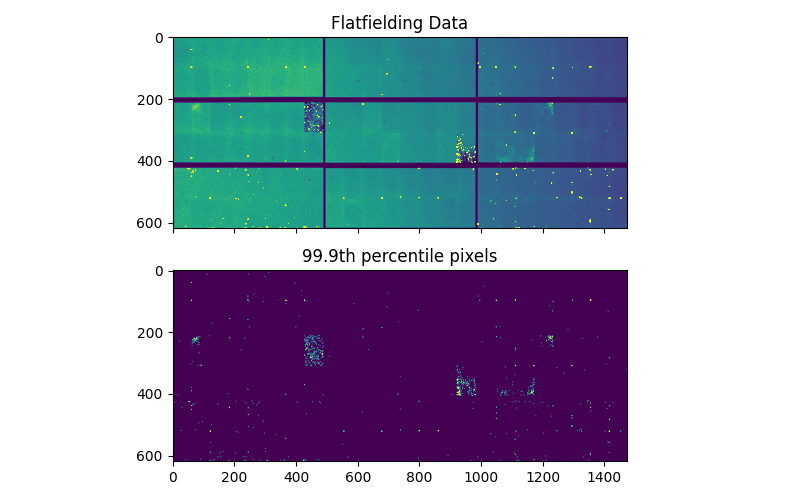

In [4]:
# Past beamline data for flat fielding (normalizing default pixel intensities)
# Note this is done at 2478eV, not all energies.

# # 2024 Cycle 2 Flatfielding
# CYCLE_FLAT = '2024_3'
# PROPOSAL_FLAT= '314483-Freychet-Flatfielding'
# FLAT_FILE = 'GF_flatfield_Sedge_2450uhighg1600_WZY11_wa30deg_2478eV_20s_id701601_000000_WAXS.tif'

# 2024 Cycle 3 Flatfielding
PROPOSAL_FLAT= '314483_Freychet_08'
FLAT_FILE = 'GF_GF_flatfield_Sedge_2450uhighg1600_Y2_06_2477.00eV_wa20deg_id807229_000000_WAXS.tif'

# Compile and load the flatfield path
FLAT_DIR_PATH = f'C:/Datasets/2024-09 SMI/{PROPOSAL_FLAT}/900KW/'
flatfield: npt.NDArray = np.rot90(fabio.open(os.path.join(FLAT_DIR_PATH, FLAT_FILE)).data, 1)

fig,ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))
p = 99.9
percentile = np.percentile(flatfield, p) #99.9th percentile
ax[0].imshow(np.rot90(flatfield, 3), vmin=0, vmax=percentile, interpolation=None)
ax[0].set_title("Flatfielding Data")

erronous =  (flatfield > percentile) * 1.0
ax[1].imshow(np.rot90(erronous,3), vmin=0, vmax=np.max(erronous)/5, interpolation=None)
ax[1].set_title(f"{p}th percentile pixels")
fig.tight_layout()
# plt.close()

### Extra functions for SMI Beamline Masking

##### Detector Masking

In [5]:
def apply_detector_mask_to_array(
        mask: npt.NDArray = np.zeros((1475, 195), dtype=bool)
        ) -> npt.NDArray[np.bool]:
        """Sets an array mask for bad pixels; should only be applied to the middle column array"""
        mask[1254:1256, 47] = True
        mask[979:1050, 0:100] = True
        mask[967, 67] = True
        mask[490:555, 100:] = True
        mask[1231:1233, 174] = True
        mask[1414: 1416, 179] = True
        mask[858:860, 5] = True
        mask[414, 6] = True
        mask[394, 138] = True
        mask[364:366, 41] = True
        mask[364:366, 96] = True
        mask[304:306, 96:98] =  True
        mask[988, 188:194] = True
        mask[:, 1] = True
        mask[473, 20] = True
        mask[98, 5] = True
        mask[141, 111] = True
        mask[240:300, 0:50] = True
        mask[300:425, 125:] = True
        mask[181:183, 97:99] = True
        mask[553:555, 99:100] = True
        return mask

def apply_detector_mask(geom: SMI_beamline.SMI_geometry) -> None:
    """Applies a pre-defined mask for the bad pixels in the SMI beamline"""
    for i, mask in enumerate(geom.masks):
        # Dead pixels in the 2nd detector strip.
        if i%3 == 1: # For multiple WAXS images, always masks the 2nd strip.
            apply_detector_mask_to_array(mask)
    return


##### Flatield Masking

In [6]:
FLATFIELD_PERCENTILE = 99.9

# For flatfielding, ignore/mask reigons between detector pixels.
FLATFIELD_SLICES = [slice(0, 195),  # Ign. flatfield above first frame
                    slice(211, 406),# Ign. flatfield outside middle  
                    slice(-195, None)] # Ign. flatfield below first frame
            
def flatfield_mask(flatfield: npt.NDArray = flatfield, 
                   percentile: float = FLATFIELD_PERCENTILE, 
                   min: float | int = 1) -> npt.NDArray[np.bool]:
        """
        Returns a mask of flatfield data as a boolean numpy array.
        
        Masks pixels above the `percentile` (by default 99.9)
        and values less than `min` (by default 1).
        """
        # Calculate the 99.9th percentile of the total flatfield data
        p = np.percentile(flatfield, percentile) #99.9th percentile
        erronous =  flatfield > p
        # Also mask negative and zero pixels
        negative = flatfield < min
        # Return the overlap of the erronous and negative masks.
        return erronous | negative

def apply_flatfield(geom: SMI_beamline.SMI_geometry, 
                    flatfield: npt.NDArray, 
                    percentile: float | int = FLATFIELD_PERCENTILE,
                    min : float | int = 1) -> None:
    """Applies a pre-defined flatfield mask and normalisation for the SMI beamline object"""
    flatmask = flatfield_mask(flatfield=flatfield, percentile=percentile, min = min)
    for i, (mask, img) in enumerate(zip(geom.masks, geom.imgs)):
        fmask_i = flatmask[:, FLATFIELD_SLICES[i % 3]]
        # Apply the masking values
        masking_values = np.where(fmask_i == True)
        mask[masking_values] = True
        # Apply the normalisation 
        # (note: can't use img /= flatfield, as casting doesn't work from int to float)
        # Image requires counts to be int32. Therefore when dividing by the flatfield, make sure every value is less than one.
        flat = flatfield[:, FLATFIELD_SLICES[i%3]] / np.max(flatfield[:, FLATFIELD_SLICES[i%3]] * ~mask)
        flat[flat < 0] = 10000 # avoid negative values
        img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
    
        # Repeat mask for very large values erronously normalised
        mask2 = flatfield_mask(flatfield=img, percentile=percentile, min = 0) # only consider positive values.
        masking_values2 = np.where(mask2 == True)
        mask[masking_values2] = True
    return


##### Show the stages of Flatfield masking

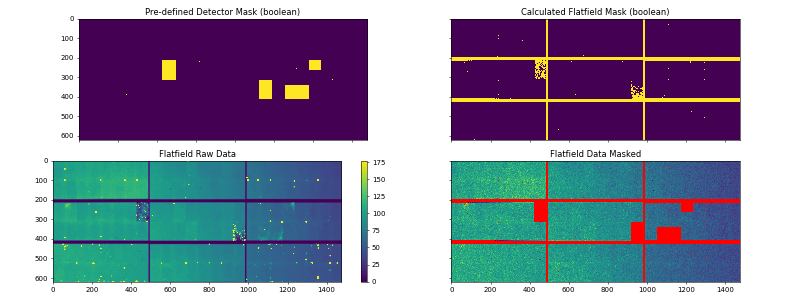

In [7]:
fig,ax = plt.subplots(2,2, figsize=(16,6), dpi=50, sharex=True, sharey=True)

# Detector image is (619, 1475) #619 is 195 * 3 + 2 * 17
# Show the detector masking
det_mask = np.c_[np.zeros((195 + 17, 1475), dtype=bool).T, 
                          apply_detector_mask_to_array(), # 195 pixels
                          np.zeros((195 + 17, 1475),dtype=bool).T]
det_im = ax[0][0].imshow(np.rot90(det_mask,3), interpolation='nearest') # required to prevent interpolation
ax[0][0].set_title("Pre-defined Detector Mask (boolean)")

# Show the flatfield masking
ff_masked = flatfield_mask(flatfield)
ff_masked_im = ax[0][1].imshow(np.rot90(ff_masked,3), interpolation='nearest') # required to prevent interpolation
ax[0][1].set_title("Calculated Flatfield Mask (boolean)")

# Show the flatfield image
ff_im = ax[1][0].imshow(np.rot90(flatfield,3), vmin = 0, vmax = np.percentile(flatfield, FLATFIELD_PERCENTILE))
plt.colorbar(ff_im)
ax[1][0].set_title("Flatfield Raw Data")

# Show the masks on the flatfield image
joined_mask = ff_masked | det_mask
cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
ff_im_masked = ax[1][1].imshow(np.rot90(flatfield,3), interpolation='nearest',
                               vmin = 0, vmax = np.percentile(flatfield, FLATFIELD_PERCENTILE))
ax[1][1].imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
ax[1][1].set_title("Flatfield Data Masked")

fig.tight_layout()
# plt.close()

### Data Import

##### Locate the files on your computer and define the output directory

In [8]:
CYCLE: str = '2024_3' #YYYY_[1-3]
PROPOSAL_ID = '316022_McNeil_04' #PPPPPP_[Name]_[#]
## ----------- Path to the raw data -----------

# RAW_PATH = f'D:/Datasets/2024-09 SMI/{CYCLE}/{PROPOSAL_ID}/900KW/'
RAW_DIR = f'C:/Datasets/2024-09 SMI/{PROPOSAL_ID}/900KW/'
display(pd.DataFrame(os.listdir(RAW_DIR), columns=["Filename"])) #use tail or head to display a subset

## ----------- Create/select the results directory -----------
RESULT_DIR = f'C:/Datasets/2024-09 SMI/{PROPOSAL_ID}/angle_scan_results/'
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)
else:
    print("Results path exists!")

Filename
0                            CM_A1_01_a_2445.00eV_ai0.80_wa0_bpm118.055_id779746_000000_WAXS.tif
1                           CM_A1_01_a_2445.00eV_ai0.80_wa20_bpm118.472_id779809_000000_WAXS.tif
2                            CM_A1_01_a_2450.00eV_ai0.80_wa0_bpm119.200_id779747_000000_WAXS.tif
3                           CM_A1_01_a_2450.00eV_ai0.80_wa20_bpm119.501_id779810_000000_WAXS.tif
4                            CM_A1_01_a_2455.00eV_ai0.80_wa0_bpm120.016_id779748_000000_WAXS.tif
...                                                                                          ...
2063  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.500_wa0_bpm119.446_id781575_000000_WAXS.tif
2064  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.600_wa0_bpm119.430_id781576_000000_WAXS.tif
2065  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.700_wa0_bpm119.493_id781577_000000_WAXS.tif
2066  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.800_wa0_bpm119.510_id781578_000000_WAXS.tif
2067  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai3.900_wa0_bpm119.436_id781579_000000_WAXS.tif

[2068 rows x 1 columns]

Results path exists!


##### Organise files into sample names and data for each detector angle

In [9]:
filename_flags: list[str] = ['wide', '2450']
"""The strings you want included in the files processed."""

# Find all samples
samples: list[str] = []
"""String names of the unique samples matching patterns in `filename_flags`"""
for file in sorted(os.listdir(RAW_DIR)):
     # Define the flags for the files you want to process, by filtering the filename.
     if all([flag in file for flag in filename_flags]):
        # Find the angle of incidence:
        idx = file.find('_ai')
        sample_substring = file[:idx+1]
        # If sample substring not in list of samples, add it!
        if sample_substring not in samples:
            samples.append(sample_substring)

# Find all TIF image measurements
datasets: list[list[str]] = [[] for _ in samples]
count = 0
"""A list for each sample, corresponding to the raw data filenames. 
Each sample list will be an index of anles of incidence."""
for i, sample in enumerate(samples):
        for j, file in enumerate(sorted(os.listdir(RAW_DIR))):
                if all([flag in file for flag in filename_flags + [sample, '.tif']]):
                        datasets[i].append(file)

# Display the number of files for each sample:
display(
      pd.DataFrame([
            (sample, len(datasets[i]))
            for i, sample in enumerate(samples)
      ], columns=["Sample Name", "Number of Files"])
)

Sample Name  Number of Files
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_              139
1  CM_wideincidentanglescan_A1_02_a_2450.00eV_              139
2  CM_wideincidentanglescan_A1_03_a_2450.00eV_              139
3  CM_wideincidentanglescan_A1_04_a_2450.00eV_              139

# Reduction
### Run the first sample to check everything is working and define the Q fit ranges

##### First check sample image exists and looks reasonable!

CM_wideincidentanglescan_A1_01_a_2450.00eV_
------------------------------
CM_wideincidentanglescan_A1_02_a_2450.00eV_
------------------------------
CM_wideincidentanglescan_A1_03_a_2450.00eV_
------------------------------
CM_wideincidentanglescan_A1_04_a_2450.00eV_
------------------------------


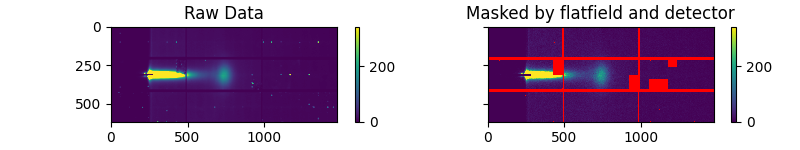

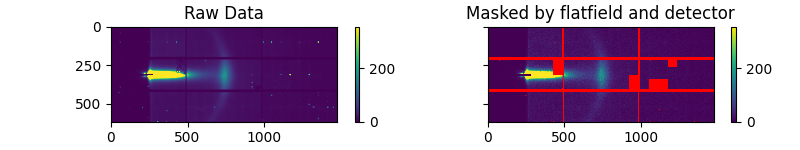

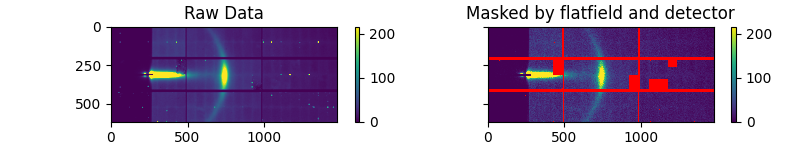

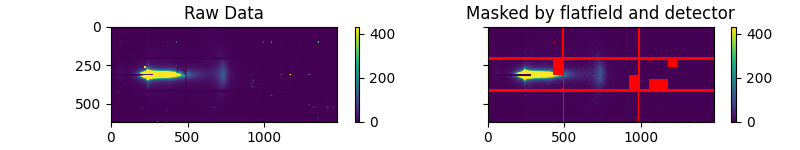

In [10]:
test_file: int = 74
"""The index of each sample's test file"""

for i, sample in enumerate(samples):
        print(sample)
        fig,ax = plt.subplots(1,2, figsize=(8,1.5), sharex=True, sharey=True)
        fname = datasets[i][test_file]
        # fig.suptitle(sample)
        # Use 
        img=fabio.open(os.path.join(RAW_DIR, fname)).data
        mappable = ax[0].imshow(img, vmin=0, vmax=np.percentile(img,99))
        ax[0].set_title("Raw Data")
        plt.colorbar(mappable)
        
        # Show the masks on the flatfield image
        cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
        ff_im_masked = ax[1].imshow(img, interpolation='nearest',
                                vmin = 0, vmax = np.percentile(img, 99))
        ax[1].imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
        ax[1].set_title("Masked by flatfield and detector")
        plt.colorbar(ff_im_masked)
        
        fig.tight_layout()
        print("------------------------------")
        # plt.close()

##### Import data via SMI beamline and observe the application of flatfielding.

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.643_wa0_bpm119.550_id779681_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_02_a_2450.00eV_ai0.643_wa0_bpm119.669_id780208_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_03_a_2450.00eV_ai0.643_wa0_bpm119.407_id780862_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai0.643_wa0_bpm119.658_id781515_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


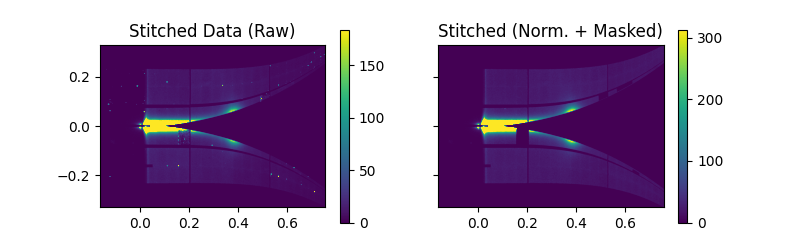

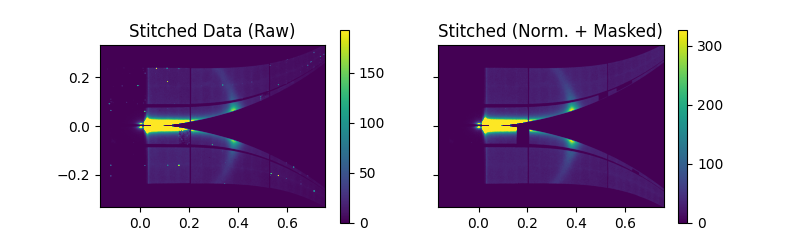

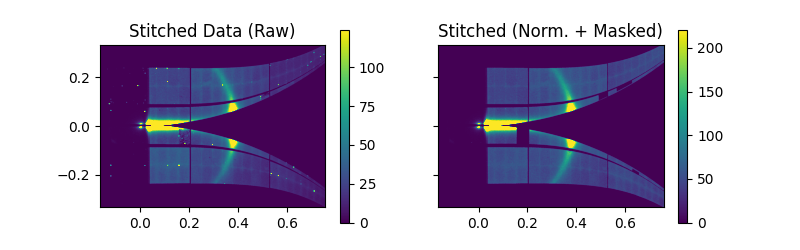

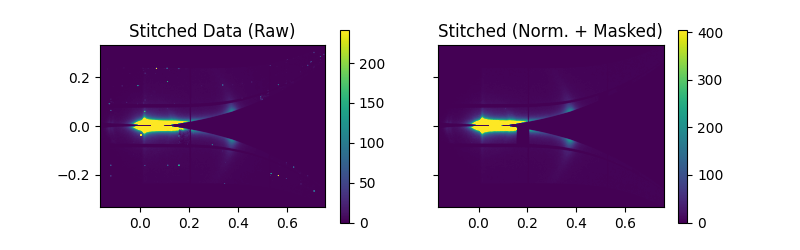

In [11]:
for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fig,ax = plt.subplots(1,2, figsize=(8,2.5), sharex=True, sharey=True)
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    display(pd.DataFrame([
            (fname, en, ai)
            ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)
    
    # Reset the masks
    for mask in SMI_waxs.masks:
        mask[:,:] = False
    
    # Plot the unmodified data
    SMI_waxs.open_data(RAW_DIR, [fname])
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
    # mp = ax[0].imshow(SMI_waxs.img_st,
    #         extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
    mp = ax[0].imshow(np.rot90(SMI_waxs.img_st.T, 2),
            extent=[SMI_waxs.qz[0], SMI_waxs.qz[-1], SMI_waxs.qp[0], SMI_waxs.qp[-1]], 
            vmin=0,
            vmax=np.percentile(SMI_waxs.img_st, 99)
    )
    plt.colorbar(mp)
    ax[0].set_title("Stitched Data (Raw)")
    
    # Plot the flatfield / masked normalized data
    SMI_waxs.open_data(RAW_DIR, [fname])
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield)
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
    # mp = ax[1].imshow(SMI_waxs.img_st,
            # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
    mp = ax[1].imshow(np.rot90(SMI_waxs.img_st.T,2),
            extent=[SMI_waxs.qz[0], SMI_waxs.qz[-1], SMI_waxs.qp[0], SMI_waxs.qp[-1]], 
            vmin=np.percentile(SMI_waxs.img_st, 1.0), 
            vmax=np.percentile(SMI_waxs.img_st, 99.0)
    )
    plt.colorbar(mp)
    ax[1].set_title("Stitched (Norm. + Masked)")
    # plt.close()


##### Generate a ROI to check the beam-centre 
###### Also check that the beamcentre is correct by symmetry (unless sample has anisotropic behavour)

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.643_wa0_bpm119.550_id779681_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_02_a_2450.00eV_ai0.643_wa0_bpm119.669_id780208_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_03_a_2450.00eV_ai0.643_wa0_bpm119.407_id780862_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai0.643_wa0_bpm119.658_id781515_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


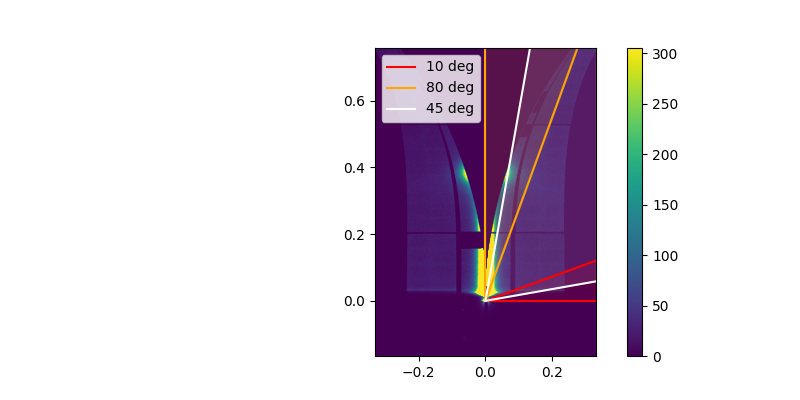

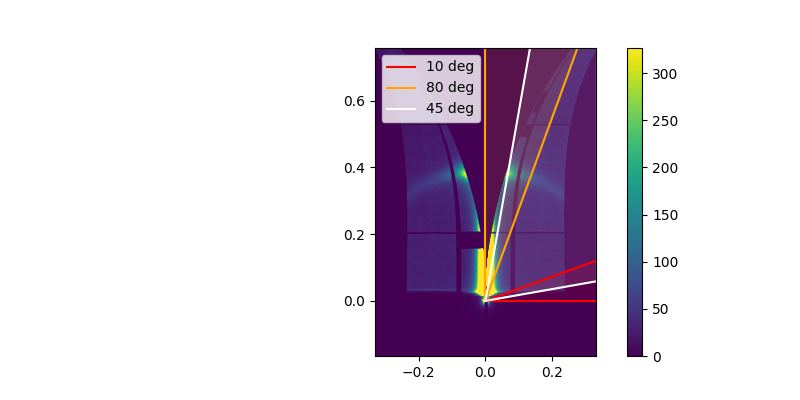

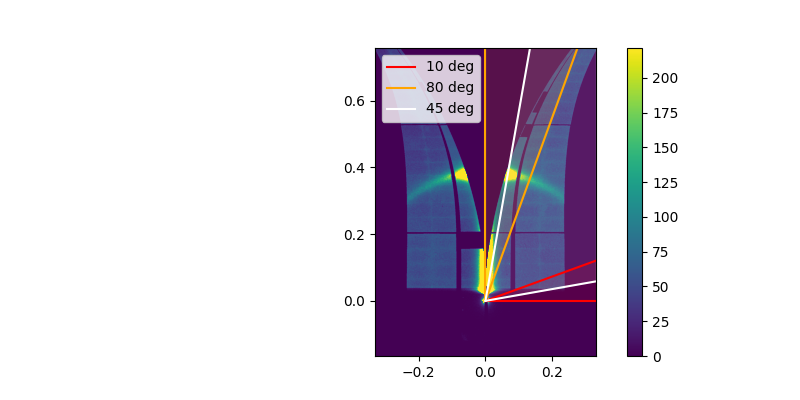

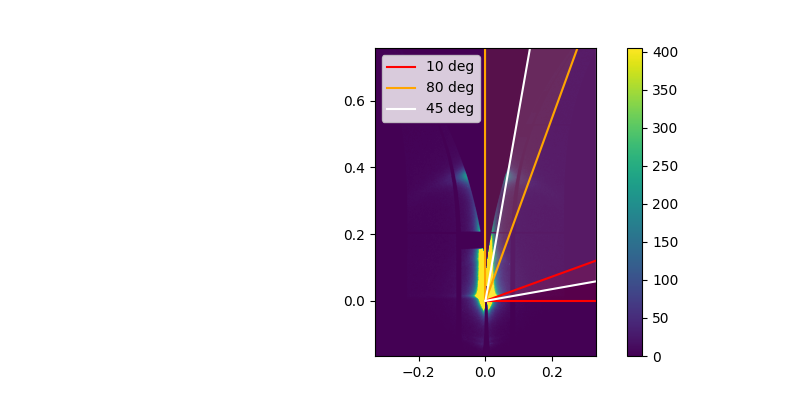

In [12]:
# Define the radial angles
AZIMUTHAL_WIDTH = 10
"""The +- azimuthal width of the orthogonal range"""
AZIMUTHAL_INPLANE = 10
"""The azimuthal angle for the in-plane scattering"""
AZIMUTHAL_OUTOFPLANE = 80
"""The azimuthal angle for the out-of-plane averaging"""
RADIAL_WIDTH = 35
"""The +- azimuthal width for the radial averaging"""
AZIMUTHAL_RADIAL = 45
"""The azimuthal angle for the radial averaging"""

for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    display(pd.DataFrame([
            (fname, en, ai)
            ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)

    # Show the angles on a plot
    fig,ax = plt.subplots(1,1, figsize=(8,4), sharex=True, sharey=True)
    ax.set_ylim(SMI_waxs.qz[0], SMI_waxs.qz[-1])
    ax.set_xlim(SMI_waxs.qp[0], SMI_waxs.qp[-1])

    SMI_waxs.open_data(RAW_DIR, [fname])
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield)
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
    # mp = ax[1].imshow(SMI_waxs.img_st,
            # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
    mp = ax.imshow(SMI_waxs.img_st,
            extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            vmin=np.percentile(SMI_waxs.img_st, 1.0), 
            vmax=np.percentile(SMI_waxs.img_st, 99.0)
    )
    plt.colorbar(mp)

    # Plot the azimuthal and radial angles
    colors = ['r', 'orange', 'white'][::-1]
    for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
            # Generate a set of x points to plot lines of.
            q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
            # Calculate the x and y gradients for the lines
            m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
            m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
            # Calculate the x & y values for the lines
            q_x1 = q_x if m1 != np.inf else np.zeros(100)
            q_x2 = q_x if m2 != np.inf else np.zeros(100)
            y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
            y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
            # Plot the lines
            color = colors.pop()
            ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
            ax.plot(q_x2, y2, color=color, linestyle='-')
            # If gradient is inf, calculate an alternative fill between
            if m2 == np.inf:
                    ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
            else:
                    ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
    ax.legend()
    # ax.close()


##### Calculate the azimuthal/radial averages

Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.643_wa0_bpm119.550_id779681_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_02_a_2450.00eV_ai0.643_wa0_bpm119.669_id780208_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_03_a_2450.00eV_ai0.643_wa0_bpm119.407_id780862_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


Filename  Energy (eV)  Incident Angle (deg)
0  CM_wideincidentanglescan_A1_04_a_2450.00eV_ai0.643_wa0_bpm119.658_id781515_000000_WAXS.tif       2450.0                 0.643

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division


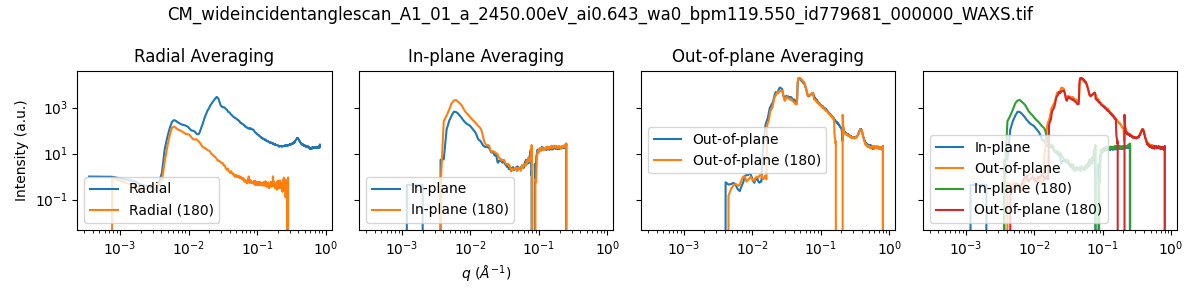

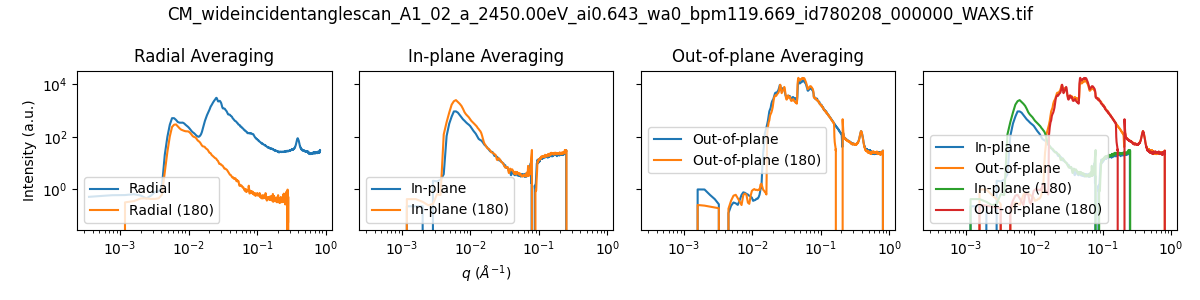

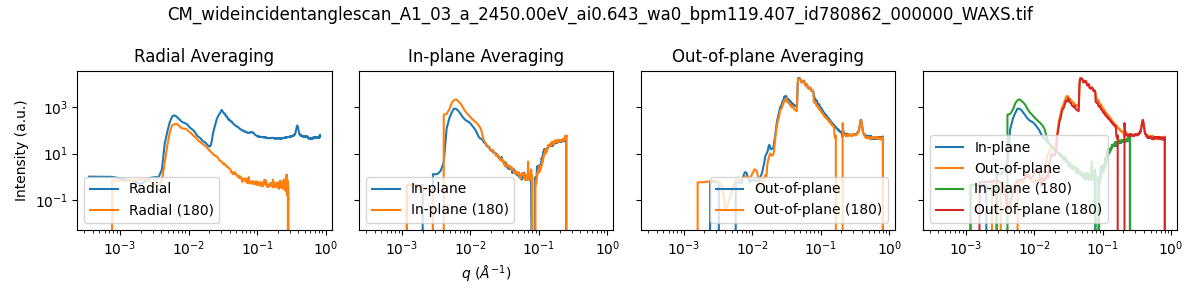

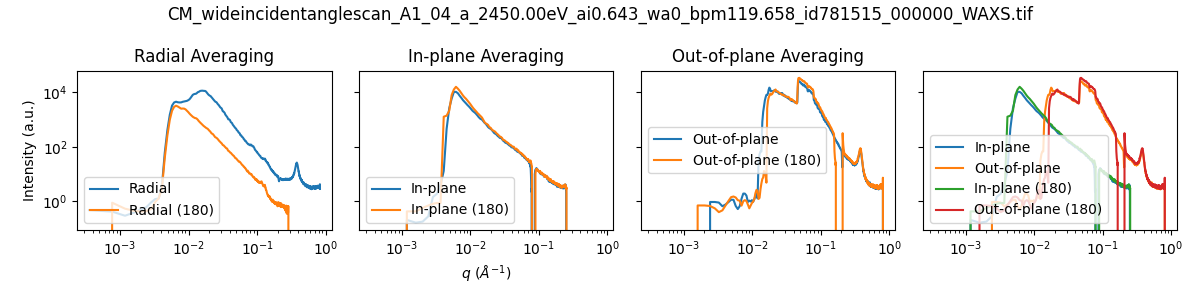

In [13]:
NPOINTS_RADIAL_AVE: int = 2000 # Use a number the is consistent with the pixel density?

for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    display(pd.DataFrame([
            (fname, en, ai)
            ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)

    # Open and stitch the data
    SMI_waxs.open_data(RAW_DIR, [fname])
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield)
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)

    # Generate radial averages
    fig,ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
    fig.suptitle(fname)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")

    # In plane and out of plane
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP, I0_IP = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP, I0_OOP = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat IP and OOP for the consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP2, I0_IP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP2, I0_OOP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Radial averaging
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[AZIMUTHAL_RADIAL - RADIAL_WIDTH , AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R, I0_R = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat radial averaging for consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[180-AZIMUTHAL_RADIAL - RADIAL_WIDTH , 180-AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R2, I0_R2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Plot the radial averages
    ax[0].plot(q0_R, I0_R, label="Radial")
    ax[0].plot(q0_R2, I0_R2, label="Radial (180)")
    ax[0].set_title("Radial Averaging")
    ax[0].set_ylabel("Intensity (a.u.)")
    # Plot the in-plane and out-of-plane averages
    ax[1].plot(q0_IP, I0_IP, label="In-plane")
    ax[1].plot(q0_IP2, I0_IP2, label="In-plane (180)")
    ax[1].set_title("In-plane Averaging")
    ax[1].set_xlabel("$q$ ($Å^{-1}$)")
    ax[2].plot(q0_OOP, I0_OOP, label="Out-of-plane")
    ax[2].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")
    ax[2].set_title("Out-of-plane Averaging")
    # Overlap the in-plane and out-of-plane averages to check for consistency
    ax[3].plot(q0_IP, I0_IP, label="In-plane")
    ax[3].plot(q0_OOP, I0_OOP, label="Out-of-plane")
    ax[3].plot(q0_IP2, I0_IP2, label="In-plane (180)")
    ax[3].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")

    for ax in ax:
            ax.legend()
    fig.tight_layout()
    # plt.close()

### Setup Fitting
##### Define q regions for truncation, where summation can be performed to observe changes in amplitude

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\3713231805.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)]), 4, figsize=(14,4))


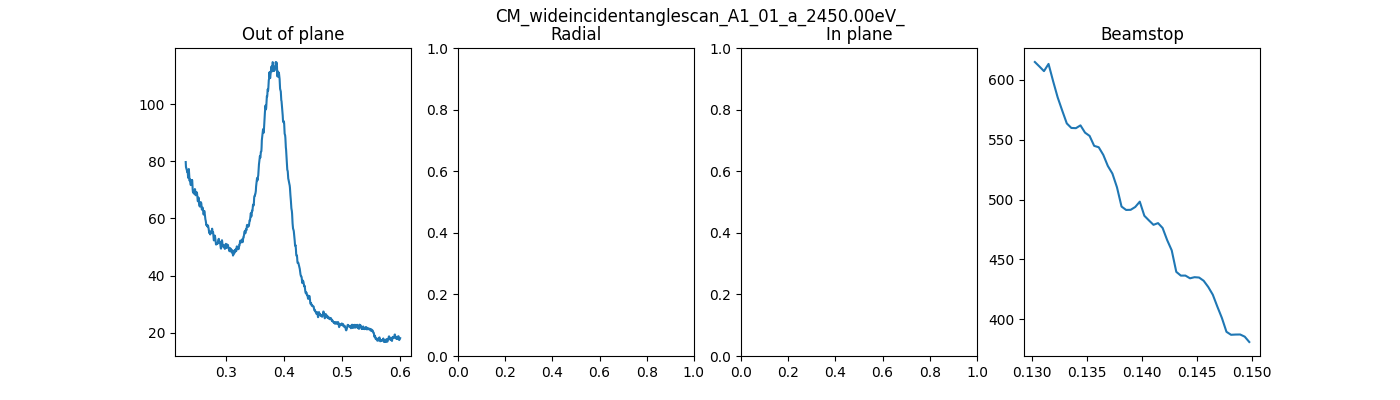

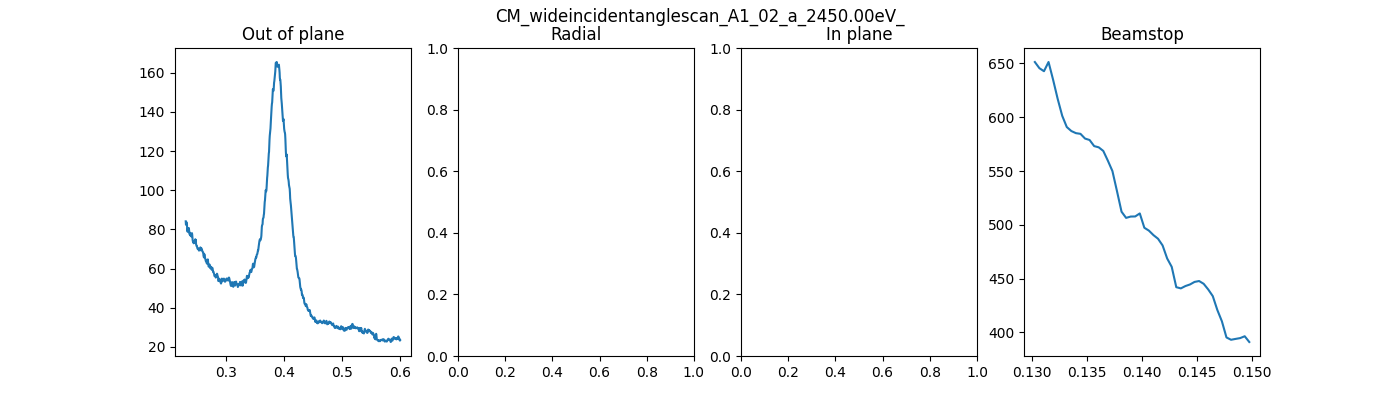

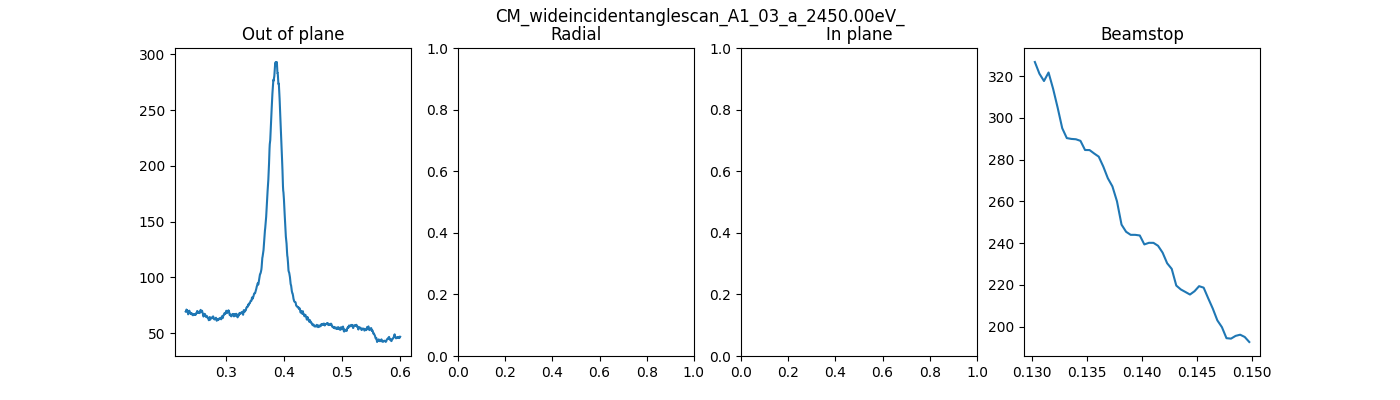

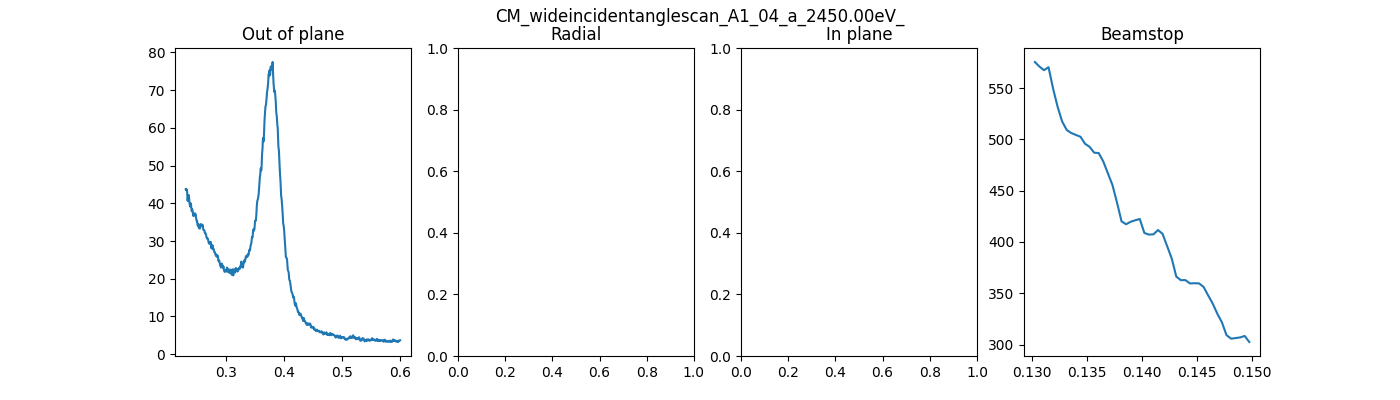

In [14]:
# Define the q-range for the peaks
VERT_PEAKS: list[tuple[float, float]] = [(0.23, 0.6),
                                    # (0.5, 0.75), etc.
                                    ]
"""A list of tuples defining the q-range fitting for each peak of interest in the out-of-plane direction"""
HOR_PEAKS: list[tuple[float, float]] = []
"""A list of tuples defining the q-range fitting for each peak of interest in the in-plane direction"""
RAD_PEAKS: list[tuple[float, float]] = []
"""A list of tuples defining the q-range fitting for each peak of interest across the azimuthal"""

VERT_BEAMSTOP: tuple[float, float] = (0.13, 0.15)
"""A q-range specifying a q-range to collect the change in beamstop intensity"""

for i, sample in enumerate(samples):
    # Setup a figure and open the file
    fname = datasets[i][test_file]
    
    # Collect the metadata
    en_idx = fname.find('eV_')
    en = float(fname[en_idx-7:en_idx])
    ai_idx = fname.find("_ai")
    ai = float(fname[ai_idx+3:ai_idx+8])
    
    # Update the geometry
    SMI_waxs.alphai = np.deg2rad(ai)
    SMI_waxs.wav = en2wav(en)
    
    # Open and stitch the data
    SMI_waxs.open_data(RAW_DIR, [fname])
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield)
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)

    # In plane and out of plane
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP, I0_IP = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP, I0_OOP = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat IP and OOP for the consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_IP2, I0_IP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_OOP2, I0_OOP2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Radial averaging
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[AZIMUTHAL_RADIAL - RADIAL_WIDTH , AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R, I0_R = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Repeat radial averaging for consistency checking
    SMI_waxs.radial_averaging(radial_range = [0, 8], 
                            azimuth_range=[180-AZIMUTHAL_RADIAL - RADIAL_WIDTH , 180-AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                            npt = NPOINTS_RADIAL_AVE)
    q0_R2, I0_R2 = SMI_waxs.q_rad, SMI_waxs.I_rad

    # Find the q-range to the region of interest
    if len(VERT_PEAKS) > 0:
        idx_OOP = np.where((q0_OOP > np.min(VERT_PEAKS)) & (q0_OOP < np.max(VERT_PEAKS)))
    else:
        idx_OOP = np.arange(len(q0_OOP))
    if len(HOR_PEAKS) > 0:
        idx_IP = np.where((q0_IP > np.min(HOR_PEAKS)) & (q0_IP < np.max(HOR_PEAKS)))
    else:
        idx_IP = np.arange(len(q0_IP))
    if len(RAD_PEAKS) > 0:
        idx_R = np.where((q0_R > np.min(RAD_PEAKS)) & (q0_R < np.max(RAD_PEAKS)))
    else:
        idx_R = np.arange(len(q0_R))
    # Collect the beamstop region
    idx_BS = np.where((q0_OOP > np.min(VERT_BEAMSTOP)) & (q0_OOP < np.max(VERT_BEAMSTOP)))
        
    # Truncate the data to the region of interest
    q0_OOP_TR, I0_OOP_TR = q0_OOP[idx_OOP], I0_OOP[idx_OOP]
    q0_IP_TR, I0_IP_TR = q0_IP[idx_IP], I0_IP[idx_IP]
    q0_R_TR, I0_R_TR = q0_R[idx_R], I0_R[idx_R]

    # Plot the data
    fig, ax = plt.subplots(max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)]), 4, figsize=(14,4))
    if len(ax.shape) == 1:
        ax = ax.reshape(1,4)
    for i, peak in enumerate(VERT_PEAKS):
        ax[i][0].plot(q0_OOP_TR, I0_OOP_TR, label="Out of plane")
    for i, peak in enumerate(RAD_PEAKS):
        ax[i][1].plot(q0_R_TR, I0_R_TR, label="Radial")
    for i, peak in enumerate(HOR_PEAKS):
        ax[i][2].plot(q0_IP_TR, I0_IP_TR, label="In plane")
    ax[0][0].set_title("Out of plane")
    ax[0][1].set_title("Radial")
    ax[0][2].set_title("In plane")

    # Plot the area under the beamstop region
    ax[0][3].plot(q0_OOP[idx_BS], I0_OOP[idx_BS], label="Beamstop")
    ax[0][3].set_title("Beamstop")
    fig.suptitle(sample)
    # plt.close()

##### Attempt some fitting of the peaks
###### Define the peakfit functions

In [15]:
power_law = lambda x, a=1, b=-1, c=0: a * (x-c)**b
"""A power law function for fitting the data

Parameters
----------
    a : float
        The amplitude of the power law, by default 1
    b : float
        The power of the power law, by default -1
    c : float
        The translational offset of the power law, by default 0
"""

lorentz = lambda x, a=1, b=1, c=1: a * c / ((x - b)**2 + c**2)
"""A Lorentzian function for fitting the data

Parameters
----------
    a : float
        The amplitude of the Lorentzian, by default 1
    b : float
        The peak position of the Lorentzian, by default 1
    c : float
        The width of the Lorentzian, by default 1
"""

gauss = lambda x, a=1, b=1, c=1: a * np.exp(-((x - b)**2) / (2 * c**2))
"""A Gaussian function for fitting the data

Parameters
----------
    a : float
        The amplitude of the Gaussian, by default 1
    b : float
        The peak position of the Gaussian, by default 1
    c : float
        The width of the Gaussian, by default 1
"""
# # Without power law centre:
fit_fn_lor = lambda x, a,b,c,d,e,f: np.sqrt((lorentz(x,a,b,c) + power_law(x,d,e))**2 + f**2)
fit_fn_lor_log = lambda x, a,b,c,d,e,f: np.log(fit_fn_lor(x,a,b,c,d,e,f))
fit_fn_gau = lambda x, a,b,c,d,e,f: np.sqrt((gauss(x,a,b,c) + power_law(x,d,e))**2 + f**2)
fit_fn_gau_log = lambda x, a,b,c,d,e,f: np.log(fit_fn_gau(x,a,b,c,d,e,f))

##### Create a reasonable guess close to the optimum

Gauss Amp.  Gauss Centre  Gauss Width  Powerlaw Amplitude  Powerlaw Power        Offset
OOP Peak #0 Fit     60.502168      0.376324     0.017476            0.944578       -2.633923  1.000000e-10
OOP Peak #0 Error    0.265287      0.000086     0.000093            0.025891        0.021011  0.000000e+00

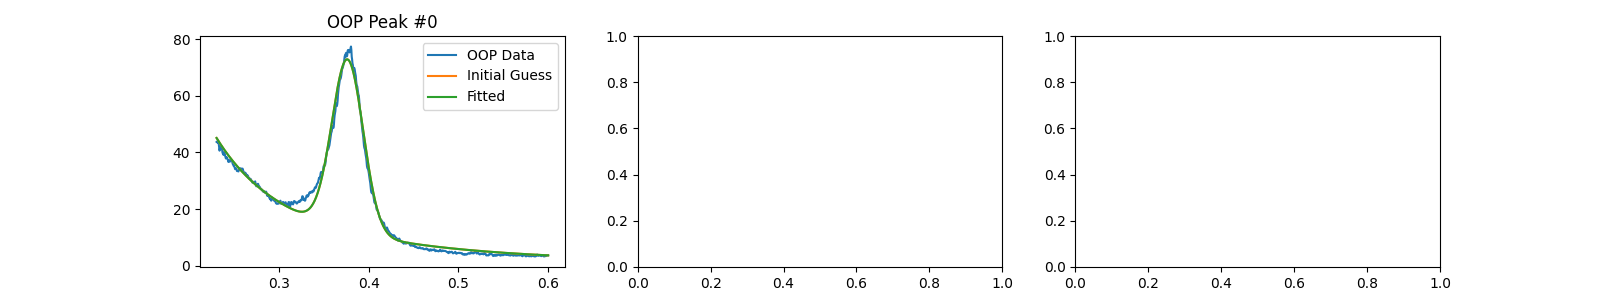

In [16]:
# Define the initial guesses for the peaks
VERT_GUESSES: list[tuple] = [
    # (50, 0.38, 0.025, 2, -2.5, 0)
    # (70.04249193592953,	0.380257511937491,	0.02381294689212496,	3.191419496644348,	-2.1283849273739874,	1e-10)
    (60.502168,	0.376319,	0.017477,	0.944565,	-2.633907,	1.000000e-10)
]
"""A list of tuples defining the initial guesses for each out-of-plane peak of interest"""
HOR_GUESSES: list[tuple] = []
"""A list of tuples defining the initial guesses for each in-plane peak of interest"""
RAD_GUESSES: list[tuple] = []
"""A list of tuples defining the initial guesses for each radial peak of interest"""

# Define the parameter labels
VERT_LABELS: list[list[str]] = [
    ["Gauss Amp.", "Gauss Centre", "Gauss Width", "Powerlaw Amplitude", "Powerlaw Power", "Offset"]
]
"""A list of lists defining the labels for the fitting parameters for each out-of-plane peak"""
HOR_LABELS: list[list[str]] = []
"""A list of lists defining the labels for the fitting parameters for each in-plane peak"""
RAD_LABELS: list[list[str]] = []
"""A list of lists defining the labels for the fitting parameters for each radial peak"""

# Fitting functions
VERT_FIT_FNS: list[Callable] = [fit_fn_gau]
"""A list of fitting functions for the out-of-plane peaks"""
HOR_FIT_FNS: list[Callable] = []
"""A list of fitting functions for the in-plane peaks"""
RAD_FIT_FNS: list[Callable] = []
"""A list of fitting functions for the radial peaks"""

#Bounds
VERT_LB : list[tuple | None] = [(0, 0, 0, 0, -np.inf, 0)]
"""List of tuples defining the lower bounds for the fitting parameters for each out-of-plane peak"""
VERT_UB : list[tuple | None] = [(np.inf, np.inf, np.inf, np.inf, 0, np.inf)]
"""List of tuples defining the upper bounds for the fitting parameters for each out-of-plane peak"""
VERT_BOUNDS : list[tuple[tuple | None, tuple | None] | None] = [(VERT_LB[i], VERT_UB[i]) for i in range(len(VERT_LB))]
"""List of tuples of lower-bound/upper-bound tuples, defining the bounds for the fitting parameters for each out-of-plane peak"""
HOR_LB : list[tuple | None] = []
"""List of tuples defining the lower bounds for the fitting parameters for each in-plane peak"""
HOR_UB : list[tuple | None] = []
"""List of tuples defining the upper bounds for the fitting parameters for each in-plane peak"""
HOR_BOUNDS : list[tuple[tuple | None, tuple | None] | None] = [(HOR_LB[i], HOR_UB[i]) for i in range(len(HOR_LB))]
"""List of tuples of lower-bound/upper-bound tuples, defining the bounds for the fitting parameters for each in-plane peak"""
RAD_LB : list[tuple | None] = []
"""List of tuples defining the lower bounds for the fitting parameters for each radial peak"""
RAD_UB : list[tuple | None] = []
"""List of tuples defining the upper bounds for the fitting parameters for each radial peak"""
RAD_BOUNDS : list[tuple[tuple | None, tuple | None] | None] = [(RAD_LB[i], RAD_UB[i]) for i in range(len(RAD_LB))]
"""List of tuples of lower-bound/upper-bound tuples, defining the bounds for the fitting parameters for each radial peak"""

# Convert (None, None) tuples to None for the bounds
VERT_BOUNDS = [None if bounds == (None, None) else bounds for bounds in VERT_BOUNDS]
HOR_BOUNDS = [None if bounds == (None, None) else bounds for bounds in HOR_BOUNDS]
RAD_BOUNDS = [None if bounds == (None, None) else bounds for bounds in RAD_BOUNDS]

# Check the number of guesses matches the number of peaks
assert len(VERT_PEAKS) == len(VERT_GUESSES) == len(VERT_BOUNDS) == len(VERT_LABELS), "The number of guesses must match the number of peaks and bounds."
assert len(HOR_PEAKS) == len(HOR_GUESSES) == len(HOR_BOUNDS) == len(HOR_LABELS), "The number of guesses must match the number of peaks and bounds."
assert len(RAD_PEAKS) == len(RAD_GUESSES) == len(RAD_BOUNDS) == len(RAD_LABELS), "The number of guesses must match the number of peaks and bounds."

# Pack the fitting functions, guesses and bounds into a single iterable
FIT_REGISTER: list[tuple[Literal["OOP"] | Literal["IP"] | Literal["RAD"],
                         tuple[float, float],
                         Callable, 
                         tuple, 
                         tuple[tuple | None, tuple | None] | None,
                         list[str]]
                   ] = []
"""A list of tuples defining:
    1. The peak type (e.g. 'OOP', 'IP', 'RAD')
    2. The peak q-range
    3. The fitting function
    4. The initial guesses tuple
    5. The bounds tuple (lower|None, upper|None) | None matching length of guesses tuple.
    6. The list of parameter labels (corresponding to 4,5).
"""
for i, peak in enumerate(VERT_PEAKS):
    FIT_REGISTER.append(("OOP", peak, VERT_FIT_FNS[i], VERT_GUESSES[i], VERT_BOUNDS[i], VERT_LABELS[i]))
for i, peak in enumerate(HOR_PEAKS):
    FIT_REGISTER.append(("IP", peak, HOR_FIT_FNS[i], HOR_GUESSES[i], HOR_BOUNDS[i], HOR_LABELS[i]))
for i, peak in enumerate(RAD_PEAKS):
    FIT_REGISTER.append(("RAD", peak, RAD_FIT_FNS[i], RAD_GUESSES[i], RAD_BOUNDS[i], RAD_LABELS[i]))

# Display the initial guesses over the data
FIT_N = max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)])
fig, ax = plt.subplots(FIT_N, 3, figsize=(16,3*FIT_N))
if len(ax.shape) == 1:
    ax = ax.reshape(1,3)

for i, fit in enumerate(FIT_REGISTER):
    peak_type, peak_range, fit_fn, guess, bounds, labels = fit
    match peak_type:
        case "OOP":
            j = 0
            q, I = q0_OOP, I0_OOP
        case "IP":
            j = 1
            q, I = q0_IP, I0_IP
        case "RAD":
            j = 2
            q, I = q0_R, I0_R
    idxs = np.where((q > peak_range[0]) & (q < peak_range[1]))
    q = q[idxs]
    I = I[idxs]
    
    ax[i][0].set_title(f"{peak_type} Peak #{i}")
    ax[i][0].plot(q, I, label=f"{peak_type} Data")
    ax[i][0].plot(q, fit_fn(q, *VERT_GUESSES[i]), label="Initial Guess")
    popt, pcov = curve_fit(fit_fn, q, I, p0=guess, maxfev=10000, bounds=bounds)
    ax[i][0].plot(q, fit_fn(q, *popt), label="Fitted")
    ax[i][0].legend()
    display(pd.DataFrame(
        [popt, np.sqrt(np.diag(pcov))],
        columns=labels,
        index=[f"{peak_type} Peak #{i} Fit", f"{peak_type} Peak #{i} Error"]
    ))


### Use Monte-Carlo Markov Chains to see if the Least Squares solution is really a good fit of random variables
##### Define the likelihood, prior and probability functions

In [17]:
def gen_fns(fit_fn: Callable, bounds: tuple[tuple | None, tuple | None] | None) -> tuple[Callable, Callable, Callable]:
    """Genereate the log-likelihood, log-prior and log-probability functions for the fitting"""
    def log_likelihood(theta, x, y, yerr, fit_fn: Callable = fit_fn) -> float:
        model_y = fit_fn(x, *theta)
        sigma2 = yerr**2
        return -0.5 * np.sum((y - model_y)**2 / sigma2 )
    
    def log_prior(theta, bounds: tuple[tuple | None, tuple | None] | None = bounds) -> float:
        """Define the log-prior function for the fitting"""
        if bounds is None:
            return 0.0
        lb, ub = bounds
        # Return -np.inf if out of bounds.
        if lb is not None:
            for i in range(len(theta)):
                if lb[i] is not None:
                    if lb[i] > theta[i]:
                        return -np.inf
        if not ub is None:
            for i in range(len(theta)):
                if ub[i] is not None:
                    if ub[i] < theta[i]:
                        return -np.inf
        return 0.0
    
    def log_probability(theta, x, y, yerr, lprior: Callable = log_prior, llikelihood: Callable = log_likelihood) -> float:
        """Define the log-probability function for the fitting"""
        lp = lprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + llikelihood(theta, x, y, yerr)
    
    return log_likelihood, log_prior, log_probability

LOG_LIKELIHOOD_FNS: list[Callable] = []
"""A list of log-likelihood functions for each peak. By default a Gaussian log-likelihood function is used for each parameter, but can be redefined."""
LOG_PRIOR_FNS: list[Callable] = []
"""A list of log-prior functions for each peak. By default no prior is defined, but can be redefined."""
LOG_PROBABILITY_FNS: list[Callable] = []

for i, fit in enumerate(FIT_REGISTER):
    peak_type, peak_range, fit_fn, guess, bounds, labels = fit
    log_likelihood, log_prior, log_probability = gen_fns(fit_fn, bounds)
    LOG_LIKELIHOOD_FNS.append(log_likelihood)
    LOG_PRIOR_FNS.append(log_prior)
    LOG_PROBABILITY_FNS.append(log_probability)

# Test the log_probability function - should be non-infinite if working.
LOG_PROBABILITY_FNS[0](
    theta=VERT_GUESSES[0],
    x=q0_OOP_TR, 
    y=I0_OOP_TR, 
    yerr=np.sqrt(I0_OOP_TR),
    lprior=LOG_PRIOR_FNS[0],
    llikelihood=LOG_LIKELIHOOD_FNS[0]
)

np.float64(-84.7911697953075)

##### Use emcee sampler to run N walkers

In [18]:
# Use the data from the first vert peak
qmin, qmax = VERT_PEAKS[0]
idxs = np.where((q0_OOP_TR > qmin) & (q0_OOP_TR < qmax))
x = q0_OOP_TR[idxs]
y = I0_OOP_TR[idxs]
yerr = np.sqrt(y)
popt, pcov = curve_fit(VERT_FIT_FNS[0], x, y, p0=VERT_GUESSES[0], maxfev=10000, bounds=VERT_BOUNDS[0])

start = time.time()

# Use the model on the first vert peak.
N = 200
pos = popt * np.ones((N, len(popt))) * (1 + (1.0e-2 * np.random.randn(N, len(popt)) - 5.0e-3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
M = 2000
sampler.run_mcmc(pos, M, progress=True)
max_tau = None
while max_tau is None:
    try:
        tau = sampler.get_autocorr_time()
        max_tau = np.max(tau)
    except emcee.autocorr.AutocorrError as e:
        tau_estimate = int(np.max(e.tau))
        print(f"Estimated max tau: {tau_estimate}, running for {50*tau_estimate} more steps.")
        sampler.run_mcmc(None, tau_estimate * 50, progress=False)
    
end = time.time()
print(f"Time taken: {end - start:.1f} seconds.")

100%|██████████| 2000/2000 [00:23<00:00, 86.18it/s]


Estimated max tau: 223, running for 11150 more steps.
Time taken: 151.7 seconds.


Text(0.5, 0.98, 'Chain Output - Corr time = 229.75 steps')

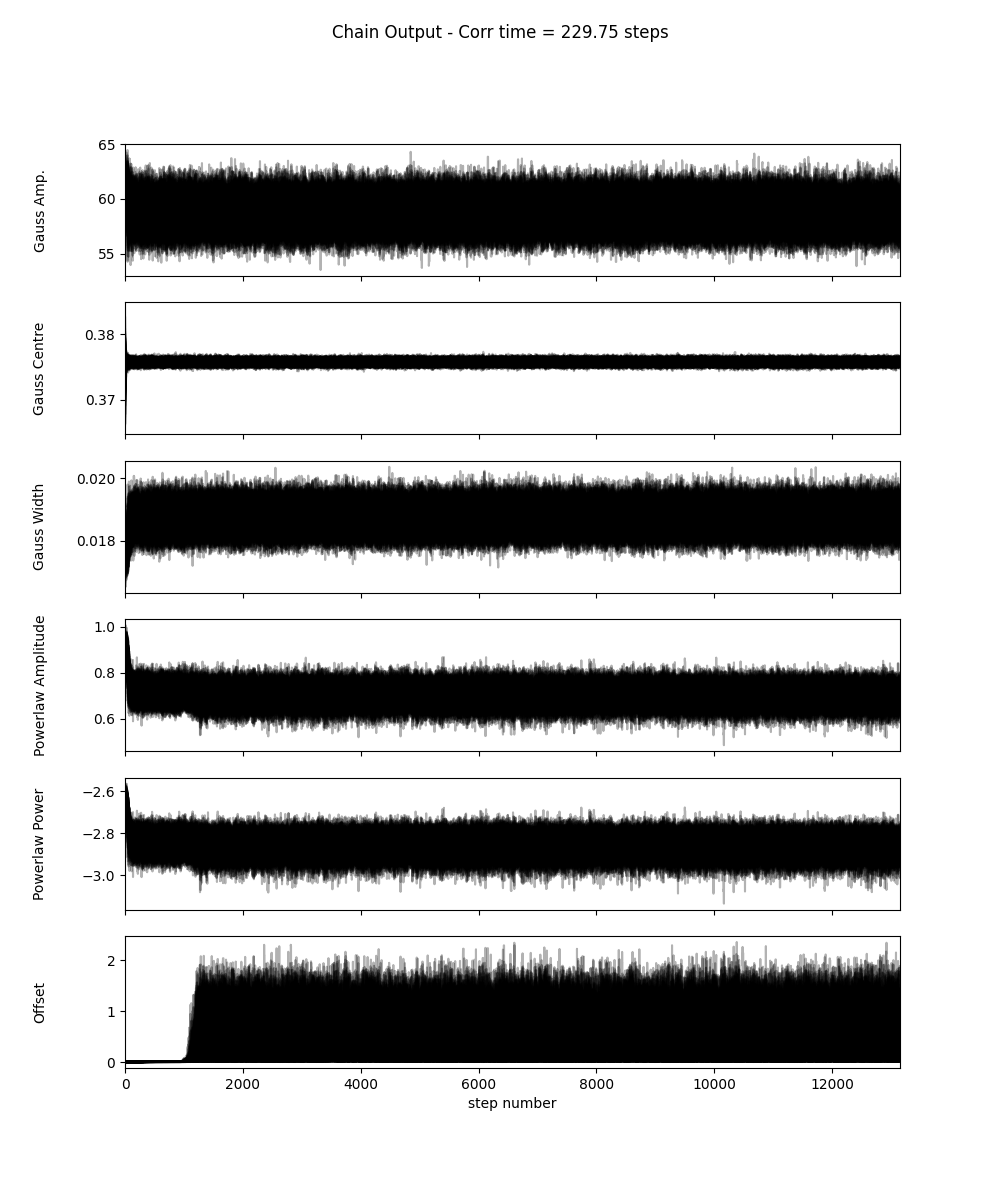

In [19]:
### Display the chain output and estimate where the burn-in period (tau) is.
fig, axes = plt.subplots(len(VERT_LABELS[0]), figsize=(10, 2*len(VERT_LABELS[0])), sharex=True)
MC_samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(MC_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(MC_samples))
    ax.set_ylabel(VERT_LABELS[0][i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
tau_max = np.max(tau)
fig.suptitle(f"Chain Output - Corr time = {tau_max:0.2f} steps")

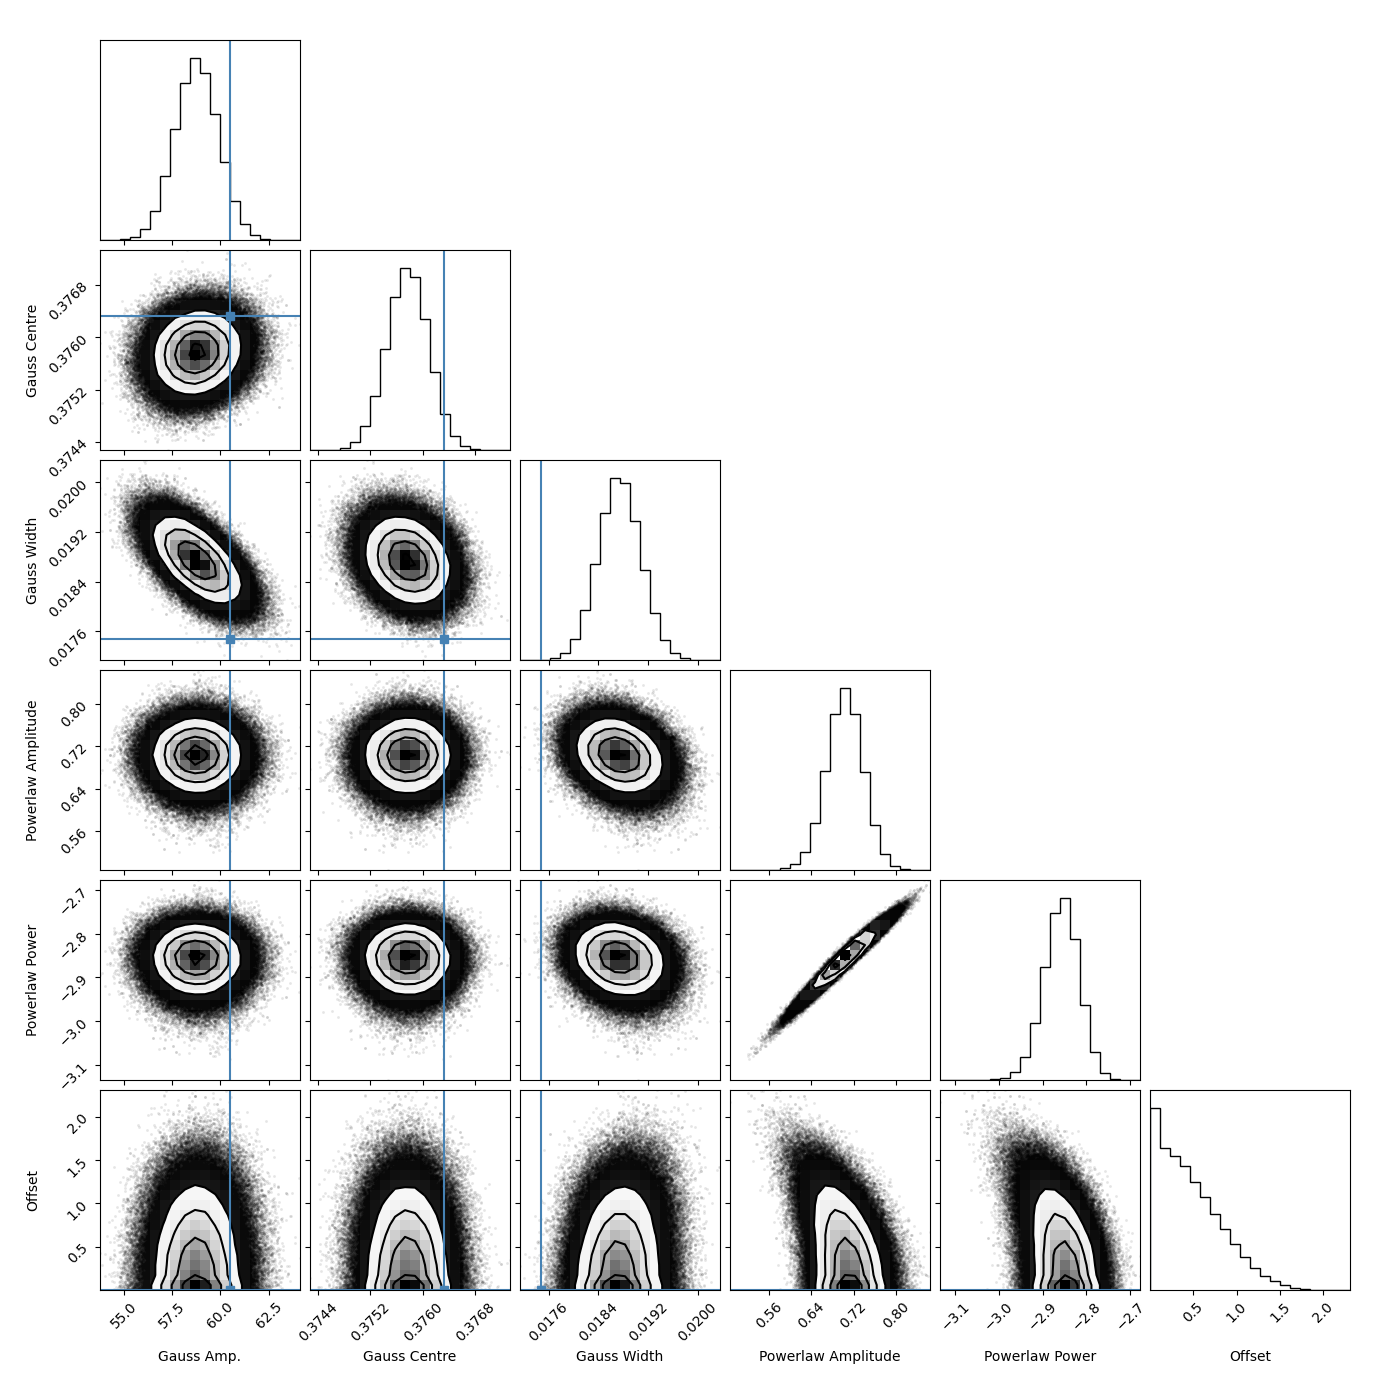

In [20]:
flat_MC_samples = sampler.get_chain(discard=int(tau_max * 3), thin=5, flat=True)
fig = corner.corner(
    flat_MC_samples, labels=VERT_LABELS[0], truths=popt
)

Gauss Amp.  Gauss Centre  Gauss Width  Powerlaw Amplitude  Powerlaw Power        Offset
Peak #5 Fit     60.502168      0.376324     0.017476            0.944578       -2.633923  1.000000e-10
Peak #5 Error    0.265287      0.000086     0.000093            0.025891        0.021011  0.000000e+00
MCMC Fit        58.763983      0.375767     0.018736            0.703644       -2.856153  3.886925e-01
MCMC LB Error   -1.114094     -0.000316    -0.000337           -0.034299       -0.040491 -3.114076e-01
MCMC UB Error    1.126165      0.000313     0.000344            0.033737        0.038514  4.497098e-01

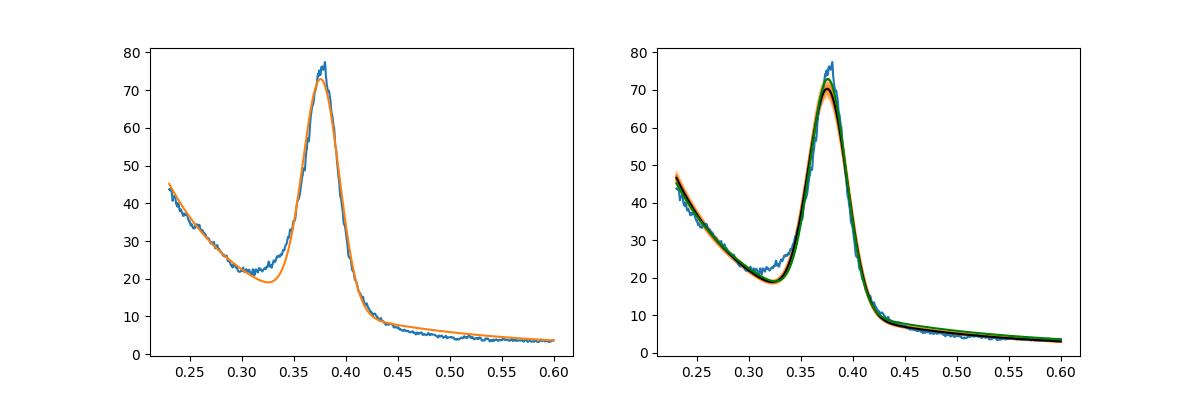

In [21]:
# Plot the result of the Least Squares fit and the MCMC fit
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
q = q0_OOP_TR[idxs]
ax[0].plot(q0_OOP_TR[idxs], I0_OOP_TR[idxs], label="Data")
ax[0].plot(q, fit_fn_gau(q, *popt), label="Least Squares Fit")
ax[0].fill_between(q, fit_fn_gau(q, *popt - np.sqrt(np.diag(pcov))), fit_fn_gau(q, *popt + np.sqrt(np.diag(pcov))), alpha=0.1)
                   
# Plot the MCMC fit
MC_samples = sampler.get_chain(discard=200, thin=5, flat=True)
percentiles = [np.percentile(MC_samples[:, i], [16, 50, 84]) for i in range(MC_samples.shape[1])] #Sampling at 1 sigma percentiles
values = [p[1] for p in percentiles]
error_bounds = np.array([[p[0] - p[1], p[2] - p[1]] for p in percentiles])


inds = np.random.randint(len(MC_samples), size=100)
for ind in inds:
    sample = MC_samples[ind]
    ax[1].plot(q, fit_fn_gau(q, *sample), "C1", alpha=0.1, label="MCMC Fit" if ind == inds[0] else None)
ax[1].plot(q0_OOP_TR[idxs], I0_OOP_TR[idxs], label="Data")
ax[1].plot(q, fit_fn_gau(q, *values), 'black', label="MCMC Fit")
ax[1].plot(q, fit_fn_gau(q, *popt), label="Least Squares Fit", c='green')


display(pd.DataFrame(
    [popt, np.sqrt(np.diag(pcov)), values, error_bounds[:,0], error_bounds[:,1]],
    columns=VERT_LABELS[0],
    index=[f"Peak #{i} Fit", f"Peak #{i} Error", "MCMC Fit", "MCMC LB Error", "MCMC UB Error"]
))

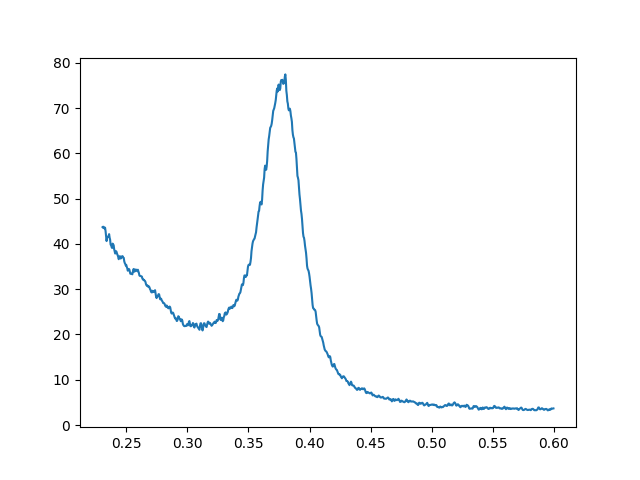

In [22]:
fig,ax = plt.subplots(1,1)
ax.plot(q,I)

### Perform analysis across all samples

In [ ]:
MCMC_SAMPLING : bool = False
"""Whether to use MCMC sampling to fit the data or not"""
N: int = 200
"""The number of walkers to use in the MCMC sampling"""
M = 1000
"""The default number of steps to use in the MCMC sampling"""

OVERRIDE: bool = False
"""Whether to override the analysis reduction or not."""

dataset_fits: list[list[np.ndarray]] = [[np.zeros(
                                            (len(datasets[i]), 1 + len(FIT_REGISTER[j][3]) * 2)
                                        )
                                        for j in range(len(FIT_REGISTER))]
                                        for i in range(len(samples))]
"""For each sample, for each peak, the parameters: the angle of incidence and a set of the least squares popt values and errors"""
dataset_MC_fits: list[list[np.ndarray]] = [[np.zeros(
                                                (len(datasets[i]), 1 + len(FIT_REGISTER[j][3]) * 3)
                                            )
                                            for j in range(len(FIT_REGISTER))]
                                            for i in range(len(samples))]
"""For each sample, for each peak, the parameters: the angle of incidence and a set of the MCMC opt values and lb/ub"""

dataset_beamstop_area: list[np.ndarray] = [np.zeros((len(datasets[i]), 3)) for i in range(len(samples))]
"""For each sample, the angle of incidence, the beamstop area and error"""

for i, sample in enumerate(samples):
    # Setup sample dependent variables
    sample_fits = dataset_fits[i]
    sample_MC_fits = dataset_MC_fits[i]
    
    # Create the results directory for the sample
    sample_dir = os.path.join(RESULT_DIR, sample)
    if not os.path.isdir(sample_dir):
        os.mkdir(sample_dir)
    giwaxs_img_dir = os.path.join(sample_dir, "giwaxs_flatfielded_images")
    if not os.path.isdir(giwaxs_img_dir):
        os.mkdir(giwaxs_img_dir)
    mcmc_img_dir = os.path.join(sample_dir, "mcmc_fit_images")
    if not os.path.isdir(mcmc_img_dir):
        os.mkdir(mcmc_img_dir)
    fits_img_dir = os.path.join(sample_dir, "ls_fit_images")
    if not os.path.isdir(fits_img_dir):
        os.mkdir(fits_img_dir)
    line_profiles_dir = os.path.join(sample_dir, "line_profiles")
    if not os.path.isdir(line_profiles_dir):
        os.mkdir(line_profiles_dir)
        
        tuple[Literal["OOP"] | Literal["IP"] | Literal["RAD"],
                         tuple[float, float],
                         Callable, 
                         tuple, 
                         tuple[tuple | None, tuple | None] | None,
                         list[str]]
        
    # Setup files to store results as they are generated
    paths_ls_fits: list[str] = [os.path.join(sample_dir, f"{sample}-{d}-{q0}_to_{q1}-ls_fits.txt") for d, (q0,q1), _, _, _, _ in FIT_REGISTER]
    paths_mcmc_fits: list[str] = [os.path.join(sample_dir, f"{sample}-{d}-{q0}_to_{q1}-mcmc_fits.txt") for d, (q0,q1), _, _, _, _ in FIT_REGISTER]
    paths_beamstop_area: str = os.path.join(sample_dir, f"{sample}-beamstop_integrated-area.txt")
    
    # First line header
    header_ls = [("\t".join(["Angle of Incidence"] + ["Fit Params"]*len(labels) + ["Fit Errors"]*len(labels) + ["Filename"])) 
                 + ("\n" + "\t".join(["Angle of Incidence"] + labels + [label + "_unc" for label in labels] + ["Filename"]))
                 for _, _, _, _, _, labels in FIT_REGISTER ]
    
    header_mcmc = [("\t".join(["Angle of Incidence"] + ["MC Fit Params"]*len(labels) + ["MC LB Errors"]*len(labels) + ["MC UB Errors"]*len(labels) + ["Filename"]))
                   + ("\n" + "\t".join(["Angle of Incidence"] + labels + [label + "_unc_lb" for label in labels] + [label + "_unc_ub" for label in labels] + ["Filename"]))
                   for _, _, _, _, _, labels in FIT_REGISTER]
    
    header_beamstop = "Angle of Incidence\tBeamstop Area\tBeamstop Area Error\tFilename"
    
    # Load the angles of incidence already processed    
    prev_ls_datasets: list[dict[str, np.ndarray]] = [{}] * len(FIT_REGISTER)
    """For each peak, a dictionary containing the previous least squares fits for each file."""
    prev_mcmc_datasets: list[dict[str, np.ndarray]] = [{}] * len(FIT_REGISTER)
    """For each peak, a dictionary containing the previous mcmc fits for each file."""
    prev_beamstop_area: dict[str, np.ndarray] = {}
    """A dictionary containing the previous beamstop area for each file."""
    
    # Iterate over each peak
    for j in range(len(FIT_REGISTER)):
        # Get the paths for the peak fit files
        path_ls_fits = paths_ls_fits[j]
        path_mcmc_fits = paths_mcmc_fits[j]
        # Check if the file exists already, and load previous/existing data.
        if os.path.isfile(path_ls_fits) and os.path.isfile(path_mcmc_fits) and not OVERRIDE:
            prev_ls_fits = np.loadtxt(path_ls_fits, delimiter="\t", skiprows=2, dtype=str)
            prev_mcmc_fits = np.loadtxt(path_mcmc_fits, delimiter="\t", skiprows=2, dtype=str)
            
            # Collect common fits and load into memory
            for fname in prev_ls_fits[:, -1]:
                # Check if the file has been MCMC fitted as well, and is loadable data:
                if fname in prev_mcmc_fits[:, -1] and fname in datasets[i]:
                    idx = np.where(prev_ls_fits[:, -1] == fname)[0][0]
                    idx2 = np.where(prev_mcmc_fits[:, -1] == fname)[0][0]
                    prev_ls_datasets[j][fname] = prev_ls_fits[idx, :-1].astype(float)
                    prev_mcmc_datasets[j][fname] = prev_mcmc_fits[idx2, :-1].astype(float)
                    
            print(f"Loaded {len(prev_ls_datasets[j])} previous fits for peak {j}.")
    
    # Load the beamstop area data
    if os.path.isfile(paths_beamstop_area) and not OVERRIDE:
        prev_beamstop_data = np.loadtxt(paths_beamstop_area, delimiter="\t", skiprows=1, dtype=str)
        for fname in prev_beamstop_data[:, -1]:
            if fname in datasets[i]:
                idx = np.where(prev_beamstop_data[:, -1] == fname)[0][0]
                prev_beamstop_area[fname] = prev_beamstop_data[idx, :-1].astype(float)
        print(f"Loaded {len(prev_beamstop_area)} previous beamstop areas.")
    
    # Begin writing the files
    open_ls_fits = [open(paths_ls_fits[j], "w") for j in range(len(FIT_REGISTER))]
    open_mcmc_fits = [open(paths_mcmc_fits[j], "w") for j in range(len(FIT_REGISTER))]
    open_beamstop_area = open(paths_beamstop_area, "w")
    try:
        # Write the headers and previous data
        for j in range(len(FIT_REGISTER)):
            open_ls_fits[j].write(header_ls[j])
            open_mcmc_fits[j].write(header_mcmc[j])
            for fname in prev_ls_datasets[j].keys():
                open_ls_fits[j].write("\n" + "\t".join([str(val) for val in prev_ls_datasets[j][fname]] + [fname]))
                open_mcmc_fits[j].write("\n" + "\t".join([str(val) for val in prev_mcmc_datasets[j][fname]] + [fname]))
        
        # Write the beamstop area header and previous data
        open_beamstop_area.write(header_beamstop)
        for fname in prev_beamstop_area.keys():
            open_beamstop_area.write("\n" + "\t".join([str(val) for val in prev_beamstop_area[fname]] + [fname]))
                
        # Loop over all files in the sample dataset
        for j, fname in enumerate(datasets[i]):
            # Check if the file has already been processed
            #-----------------------------------------------
            if not OVERRIDE and all(
                [fname in prev_ls_dataset.keys() and fname in prev_mcmc_dataset.keys()
                 for prev_ls_dataset, prev_mcmc_dataset in zip(prev_ls_datasets, prev_mcmc_datasets)]
                ):
                print(f"File data already exists for all peaks, skipping `{fname}`.")
                # Reload the existing data and skip.
                for k in range(len(FIT_REGISTER)):
                    dataset_fits[i][k][j,:] = prev_ls_datasets[k][fname]
                    dataset_MC_fits[i][k][j,:] = prev_mcmc_datasets[k][fname]
                    # Remove data from the previous datasets
                    del prev_ls_datasets[k][fname]
                    del prev_mcmc_datasets[k][fname]
                    
                if fname in prev_beamstop_area:
                    dataset_beamstop_area[i][j,:] = prev_beamstop_area[fname]
                    # Remove data from the previous datasets
                    del prev_beamstop_area[fname]
                continue
            
            ### Otherwise, load the data and perform the fits
            #-----------------------------------------------
            
            # Setup a figure and open the file
            fig,ax = plt.subplots(1,1, figsize=(7, 10), dpi=300)
            # Collect the metadata
            en_idx = fname.find('eV_')
            en = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai = float(fname[ai_idx+3:ai_idx+8])
            
            # Setup the file dependent output paths
            path_det_img = os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{en:0.2f}eV_{ai:0.3f}deg.png")
            path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_line_profile_angles.png")
            path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_IP.txt")
            path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_OOP.txt")
            path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_R.txt")
            path_B = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_Beamstop.txt")
            
            # Update the geometry
            SMI_waxs.alphai = np.deg2rad(ai)
            SMI_waxs.wav = en2wav(en)
            
            # Plot the flatfield / masked normalized data
            SMI_waxs.open_data(RAW_DIR, [fname])
            apply_detector_mask(SMI_waxs)
            apply_flatfield(SMI_waxs, flatfield)
            SMI_waxs.stitching_data(interp_factor=3, flag_scale=False)
            mp = ax.imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            # mp = ax.imshow(np.rot90(SMI_waxs.img_st.T,2),
                    # extent=[SMI_waxs.qz[0], SMI_waxs.qz[-1], SMI_waxs.qp[0], SMI_waxs.qp[-1]], 
                    vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                    vmax=np.percentile(SMI_waxs.img_st, 99.0) # Avoid extremities
            )
            plt.colorbar(mp)
            ax.set_title(f"{sample}\n{en} eV - {ai} deg")
            fig.savefig(path_det_img)
            
            if j==0:
                # Plot the azimuthal and radial angles
                colors = ['r', 'orange', 'white'][::-1]
                for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                    # Generate a set of x points to plot lines of.
                    q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                    # Calculate the x and y gradients for the lines
                    m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                    m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                    # Calculate the x & y values for the lines
                    q_x1 = q_x if m1 != np.inf else np.zeros(100)
                    q_x2 = q_x if m2 != np.inf else np.zeros(100)
                    y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                    y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                    # Plot the lines
                    color = colors.pop()
                    ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                    ax.plot(q_x2, y2, color=color, linestyle='-')
                    # If gradient is inf, calculate an alternative fill between
                    if m2 == np.inf:
                            ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                    else:
                            ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
                ax.set_xlim(*SMI_waxs.qp)
                ax.set_ylim(*SMI_waxs.qz)
                ax.legend()
                fig.savefig(path_det_line_profiles_img, dpi=300)
            plt.close() # Save memory
            
            # Perform the radial/azimuthal averaging
            # In plane and out of plane
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                npt = NPOINTS_RADIAL_AVE)
            q0_IP, I0_IP = SMI_waxs.q_rad, SMI_waxs.I_rad
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                npt = NPOINTS_RADIAL_AVE)
            q0_OOP, I0_OOP = SMI_waxs.q_rad, SMI_waxs.I_rad
            # Repeat IP and OOP for the consistency checking
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                npt = NPOINTS_RADIAL_AVE)
            q0_IP2, I0_IP2 = SMI_waxs.q_rad, SMI_waxs.I_rad
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                npt = NPOINTS_RADIAL_AVE)
            q0_OOP2, I0_OOP2 = SMI_waxs.q_rad, SMI_waxs.I_rad
            # Radial averaging
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                azimuth_range=[AZIMUTHAL_RADIAL - RADIAL_WIDTH , AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                npt = NPOINTS_RADIAL_AVE)
            q0_R, I0_R = SMI_waxs.q_rad, SMI_waxs.I_rad
            # Repeat radial averaging for consistency checking
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                azimuth_range=[180-AZIMUTHAL_RADIAL - RADIAL_WIDTH , 180-AZIMUTHAL_RADIAL + RADIAL_WIDTH], 
                npt = NPOINTS_RADIAL_AVE)
            q0_R2, I0_R2 = SMI_waxs.q_rad, SMI_waxs.I_rad
            
            # Beamstop region of interest:
            BS_idx = np.where((q0_OOP > VERT_BEAMSTOP[0]) & (q0_OOP < VERT_BEAMSTOP[1]))
            q0_BS, I0_BS = q0_OOP[BS_idx], I0_OOP[BS_idx]
            beamstop_data = [ai, np.trapezoid(I0_BS, q0_BS), np.trapezoid(np.sqrt(I0_BS), q0_BS)]
            dataset_beamstop_area[i][j, :] = beamstop_data
            open_beamstop_area.write("\n" + "\t".join([str(param) for param in (beamstop_data + [fname])]))
            
            # Save the line profiles 
            header = "Main Data\t\tMirror-Y axis Data\t\n" + "q (Å^-1)\tI (a.u.)\tq (Å^-1)\tI (a.u.)"
            delim = "\t"
            kwargs = {"header": header, "delimiter": delim}
            np.savetxt(path_OOP, np.array([q0_IP, I0_IP, q0_IP2, I0_IP2]).T, **kwargs)
            np.savetxt(path_IP, np.array([q0_OOP, I0_OOP, q0_OOP2, I0_OOP2]).T, **kwargs)
            np.savetxt(path_R, np.array([q0_R, I0_R, q0_R2, I0_R2]).T, **kwargs)
            
            # Perform a fit to the data for each listed peak.
            for k, (d, peak, fit_fn, guess, bounds, labels) in enumerate(FIT_REGISTER):
                # Setup the data
                if d == "OOP":
                    q, I = q0_OOP, I0_OOP
                elif d == "IP":
                    q, I = q0_IP, I0_IP
                elif d == "RAD":
                    q, I = q0_R, I0_R
                    
                # Define the output paths
                path_fit_img = os.path.join(fits_img_dir, f"{sample}_fit-{en:0.2f}eV-{ai:0.3f}deg-{d}_peak_{peak[0]}-{peak[1]}_perÅ.png")
                path_mc_chain = os.path.join(mcmc_img_dir, f"mcmc_chain-{sample}-{en:0.2f}eV-{ai:0.3f}deg-{d}_peak_{peak[0]}-{peak[1]}_perÅ.png")
                path_mc_corner_plot = os.path.join(mcmc_img_dir, f"corner_plot-{sample}-{en:0.2f}eV-{ai:0.3f}deg-{d}_peak_{peak[0]}-{peak[1]}_perÅ.png")
                
                # Collect the fit subset data, perform a least squres fit    
                idx = np.where((q > peak[0]) & (q < peak[1]))
                q, I = q[idx], I[idx]
                try:
                    popt, pcov = curve_fit(fit_fn, q, I, p0=guess, maxfev=100000, bounds=bounds)
                except RuntimeError as e:
                    if j > 0:
                        print("Re-attempting fit again with previous fit as guess.")
                        popt, pcov = curve_fit(fit_fn, q, I, p0=dataset_fits[i][k][j-1, 1:1+len(guess)], maxfev=100000, bounds=bounds)
                    else:
                        raise e
                data_line = np.r_[[ai], popt, np.sqrt(np.diag(pcov))]
                dataset_fits[i][k][j, :] = data_line
                open_ls_fits[k].write("\n" + "\t".join([str(val) for val in data_line] + [fname])) #Save the data

                # Plot the fit
                fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
                ax.plot(q, I, label="Data")
                ax.plot(q, fit_fn(q, *popt), label="Least Squares Fit")
                ax.fill_between(q, fit_fn(q, *popt - np.sqrt(np.diag(pcov))), fit_fn(q, *popt + np.sqrt(np.diag(pcov))), alpha=0.1)
                ax.set_ylim(0, 1.1 * np.max(I))
                ax.set_title(f"{sample} - {en} eV - {ai} deg - Peak {peak[0]}-{peak[1]}")
                fig.savefig(path_fit_img)
                plt.close() # Save memory
                
                # Create the MCMC fitter
                init_position = (popt * np.ones((N, len(popt))) # Add some small random magnitude variance on each parameter.
                                * (1 + (1.0e-2 * np.random.randn(N, len(popt)) - 5.0e-3))) 
                nwalkers, ndim = init_position.shape
                sampler = emcee.EnsembleSampler(
                    nwalkers, ndim, LOG_PROBABILITY_FNS[k], args=(q, I, np.sqrt(I)  , LOG_PRIOR_FNS[k], LOG_LIKELIHOOD_FNS[k])
                )
                # Run for M steps
                sampler.run_mcmc(init_position, M, progress=True)
                # Check the autocorrelation time, and run for more steps if necessary.
                max_tau = None
                sample_attempts = 1
                while max_tau is None:
                    try:
                        tau = sampler.get_autocorr_time()
                        max_tau = np.nanmax(tau)
                    except emcee.autocorr.AutocorrError as e:
                        if np.isnan(e.tau).all():
                            print("Nan tau, running for 1000 more steps.")
                            sampler.run_mcmc(None, 1000, progress=False)
                        else:
                            tau_estimate = int(np.nanmax(e.tau))
                            print(f"Estimated max tau: {tau_estimate}, running for {50*tau_estimate} more steps.")
                            sampler.run_mcmc(None, tau_estimate * 50, progress=False)
                    sample_attempts += 1
                    if sample_attempts > 10: # Break if the sample attempts exceed 10
                        break
                    
                # Skip the MCMC fit if the sample attempts exceed 10.
                if sample_attempts > 10:
                    print("Max sample attempts reached. Skipping MCMC fit.")
                    dataset_MC_fits[i][k][j,:] = np.full((1 + len(labels)*3, ), np.nan)
                    continue
                
                # Create a default max_tau value if it is not found.
                if np.isnan(max_tau):
                    max_tau = 0
                    
                # Get the samples and discard some for the burn-in period
                MC_samples = sampler.get_chain()
                flat_MC_samples = sampler.get_chain(discard=int(max_tau * 3), thin=5, flat=True)

                # Save the MCMC fit results
                percentiles = [np.percentile(MC_samples[:, :, z], [16, 50, 84]) for z in range(MC_samples.shape[2])] #Sampling at 1 sigma percentiles
                values = np.array([p[1] for p in percentiles])
                gauss_error = np.array([[p[0] - p[1], p[2] - p[1]] for p in percentiles])
                
                mc_data_line = np.r_[[ai], values, gauss_error[:,0], gauss_error[:,1]]
                # Save the MC data to the open file
                open_mcmc_fits[k].write("\n" + "\t".join([str(val) for val in mc_data_line] + [fname]))
                dataset_MC_fits[i][k][j, :] = mc_data_line
                
                # Plot the chain output
                fig, axes = plt.subplots(len(labels), figsize=(10, 2*len(labels)), sharex=True)
                for z in range(ndim):
                    ax = axes[z]
                    ax.plot(MC_samples[:, :, z], "k", alpha=0.3)
                    ax.set_xlim(0, len(MC_samples))
                    ax.set_ylabel(labels[z])
                    ax.yaxis.set_label_coords(-0.1, 0.5)
                axes[-1].set_xlabel("step number")
                fig.suptitle(f"Chain Output - Corr time = {max_tau:0.2f} steps")
                fig.savefig(path_mc_chain)
                plt.close()
            
                # Create a corner plot        
                fig = corner.corner(
                    flat_MC_samples, labels=labels, truths=popt
                )
                fig.savefig(path_mc_corner_plot)
                plt.close()
            plt.close("all")
            
        # Close the files
        for f1, f2 in zip(open_ls_fits, open_mcmc_fits):
            f1.close()
            f2.close()
        open_beamstop_area.close()
        
        # Generate final graphics for the angle of incidence fits to each peak.
        #-----------------------------------------------------------------------
        for k, (d, peak, fit_fn, guess, bounds, labels) in enumerate(FIT_REGISTER):
            path_ls_summary = os.path.join(sample_dir, f"{sample}_ls_fits_summary.png")
            path_mcmc_summary = os.path.join(sample_dir, f"{sample}_mcmc_fits_summary.png")
            path_overlap_summary = os.path.join(sample_dir, f"{sample}_overlap_fits_summary.png")
        
            # Load the data
            ls_fits = dataset_fits[i][k]
            MC_fits = dataset_MC_fits[i][k]
            # Re-index the data
            angles = ls_fits[:, 0]
            ls_popt = ls_fits[:, 1:1+len(labels)]
            ls_errors = ls_fits[:, 1+len(labels):]
            MC_popt = MC_fits[:, 1:1+len(labels)]
            MC_lb_errors = MC_fits[:, 1+len(labels):1+2*len(labels)]
            MC_ub_errors = MC_fits[:, 1+2*len(labels):]
            
            # Plot the LS data
            fig, ax = plt.subplots(len(labels), 1, figsize=(4, 2*len(labels)))
            for z in range(len(labels)):
                ax[z].plot(angles, ls_popt[:, z], label=labels[z])
                ax[z].fill_between(angles, ls_popt[:, z] - ls_errors[:, z], ls_popt[:, z] + ls_errors[:, z], alpha=0.1)
                ax[z].set_ylabel(labels[z])
            fig.suptitle(f"{sample}\n{d} Peak {peak[0]:0.2f} to {peak[1]:0.2f} - Least Squares Fit Summary")
            fig.savefig(path_ls_summary)
            plt.close()
            
            # Plot the MCMC data
            fig, ax = plt.subplots(len(labels), 1, figsize=(4, 2*len(labels)))
            for z in range(len(labels)):
                ax[z].plot(angles, MC_popt[:, z], label=labels[z])
                ax[z].fill_between(angles, MC_popt[:, z] - MC_lb_errors[:, z], MC_popt[:, z] + MC_ub_errors[:, z], alpha=0.1)
                ax[z].set_ylabel(labels[z])
            fig.suptitle(f"{sample}\n{d} Peak {peak[0]:0.2f} to {peak[1]:0.2f} - MCMC Fit Summary")
            fig.savefig(path_mcmc_summary)
            plt.close()
            
            # Plot the overlap data
            fig, ax = plt.subplots(len(labels), 1, figsize=(4, 2*len(labels)))
            for z in range(len(labels)):
                ax[z].plot(angles, ls_popt[:, z], label="Least Squares Fit")
                ax[z].fill_between(angles, ls_popt[:, z] - ls_errors[:, z], ls_popt[:, z] + ls_errors[:, z], alpha=0.1)
                ax[z].plot(angles, MC_popt[:, z], label="MCMC Fit")
                ax[z].fill_between(angles, MC_popt[:, z] - MC_lb_errors[:, z], MC_popt[:, z] + MC_ub_errors[:, z], alpha=0.1)
                ax[z].set_ylabel(labels[z])
                ax[z].legend()
            fig.suptitle(f"{sample}\n{d} Peak {peak[0]:0.2f} to {peak[1]:0.2f} - MCMC/LS Fit Overlap Summary")
            fig.savefig(path_overlap_summary)
            plt.close()
    except Exception as e:
        print(f"Error processing {sample}: {e}")
        # Close the files
        for f1, f2 in zip(open_ls_fits, open_mcmc_fits):
            f1.close()
            f2.close()
        open_beamstop_area.close()
        raise e

Loaded 94 previous fits for peak 0.
Loaded 46 previous beamstop areas.
File data already exists for all peaks, skipping `CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.200_wa0_bpm119.375_id779607_000000_WAXS.tif`.
File data already exists for all peaks, skipping `CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.220_wa0_bpm119.401_id779608_000000_WAXS.tif`.
File data already exists for all peaks, skipping `CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.240_wa0_bpm119.425_id779609_000000_WAXS.tif`.
File data already exists for all peaks, skipping `CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.260_wa0_bpm119.413_id779610_000000_WAXS.tif`.
File data already exists for all peaks, skipping `CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.280_wa0_bpm119.253_id779611_000000_WAXS.tif`.
File data already exists for all peaks, skipping `CM_wideincidentanglescan_A1_01_a_2450.00eV_ai0.300_wa0_bpm119.266_id779612_000000_WAXS.tif`.
File data already exists for all peaks, skipping `CM_wideincidentangles

C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 84.87it/s]


Estimated max tau: 58, running for 2900 more steps.
Estimated max tau: 372, running for 18600 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 83.76it/s]


Estimated max tau: 75, running for 3750 more steps.
Estimated max tau: 410, running for 20500 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 84.02it/s]


Estimated max tau: 73, running for 3650 more steps.
Estimated max tau: 386, running for 19300 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 83.72it/s]


Estimated max tau: 77, running for 3850 more steps.
Estimated max tau: 431, running for 21550 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s]


Estimated max tau: 74, running for 3700 more steps.
Estimated max tau: 444, running for 22200 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 84.33it/s]


Estimated max tau: 69, running for 3450 more steps.
Estimated max tau: 393, running for 19650 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 83.63it/s]


Estimated max tau: 71, running for 3550 more steps.
Estimated max tau: 427, running for 21350 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 84.78it/s]


Estimated max tau: 69, running for 3450 more steps.
Estimated max tau: 406, running for 20300 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 84.41it/s]


Estimated max tau: 74, running for 3700 more steps.
Estimated max tau: 421, running for 21050 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 83.74it/s]


Estimated max tau: 73, running for 3650 more steps.
Estimated max tau: 425, running for 21250 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 83.51it/s]


Estimated max tau: 77, running for 3850 more steps.
Estimated max tau: 428, running for 21400 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 83.38it/s]


Estimated max tau: 63, running for 3150 more steps.
Estimated max tau: 415, running for 20750 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:11<00:00, 83.52it/s]


Estimated max tau: 67, running for 3350 more steps.
Estimated max tau: 411, running for 20550 more steps.


C:\Users\Mr_G\AppData\Local\Temp\ipykernel_23848\1553612356.py:41: RuntimeWarning: invalid value encountered in cast
  img[:] = img / ((flat * ~mask)+1E-7) # Add a little to avoid zero division
100%|██████████| 1000/1000 [00:12<00:00, 83.23it/s]


Estimated max tau: 65, running for 3250 more steps.
Estimated max tau: 397, running for 19850 more steps.


In [ ]:
raise RuntimeError("Stop Here.")

Text(0.5, 0, 'step number')

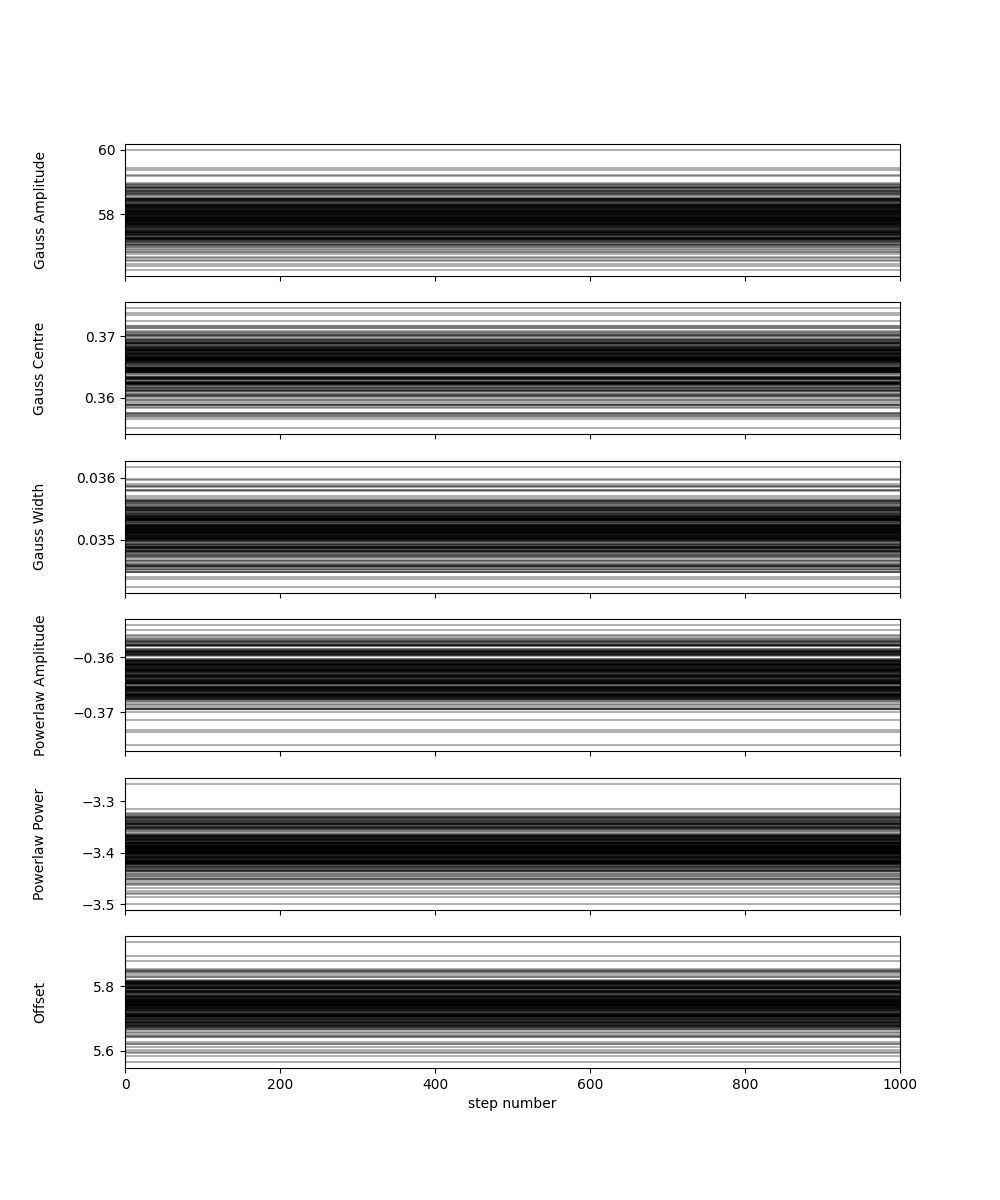

In [48]:
fig, axes = plt.subplots(len(gauss_labels), figsize=(10, 2*len(gauss_labels)), sharex=True)
MC_samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(MC_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(MC_samples))
    ax.set_ylabel(gauss_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
# tau_max = np.nanmax(tau) if tau is not np.nan else 200
# fig.suptitle(f"Chain Output - Corr time = {tau_max:0.2f} steps")

<IPython.core.display.Javascript object>


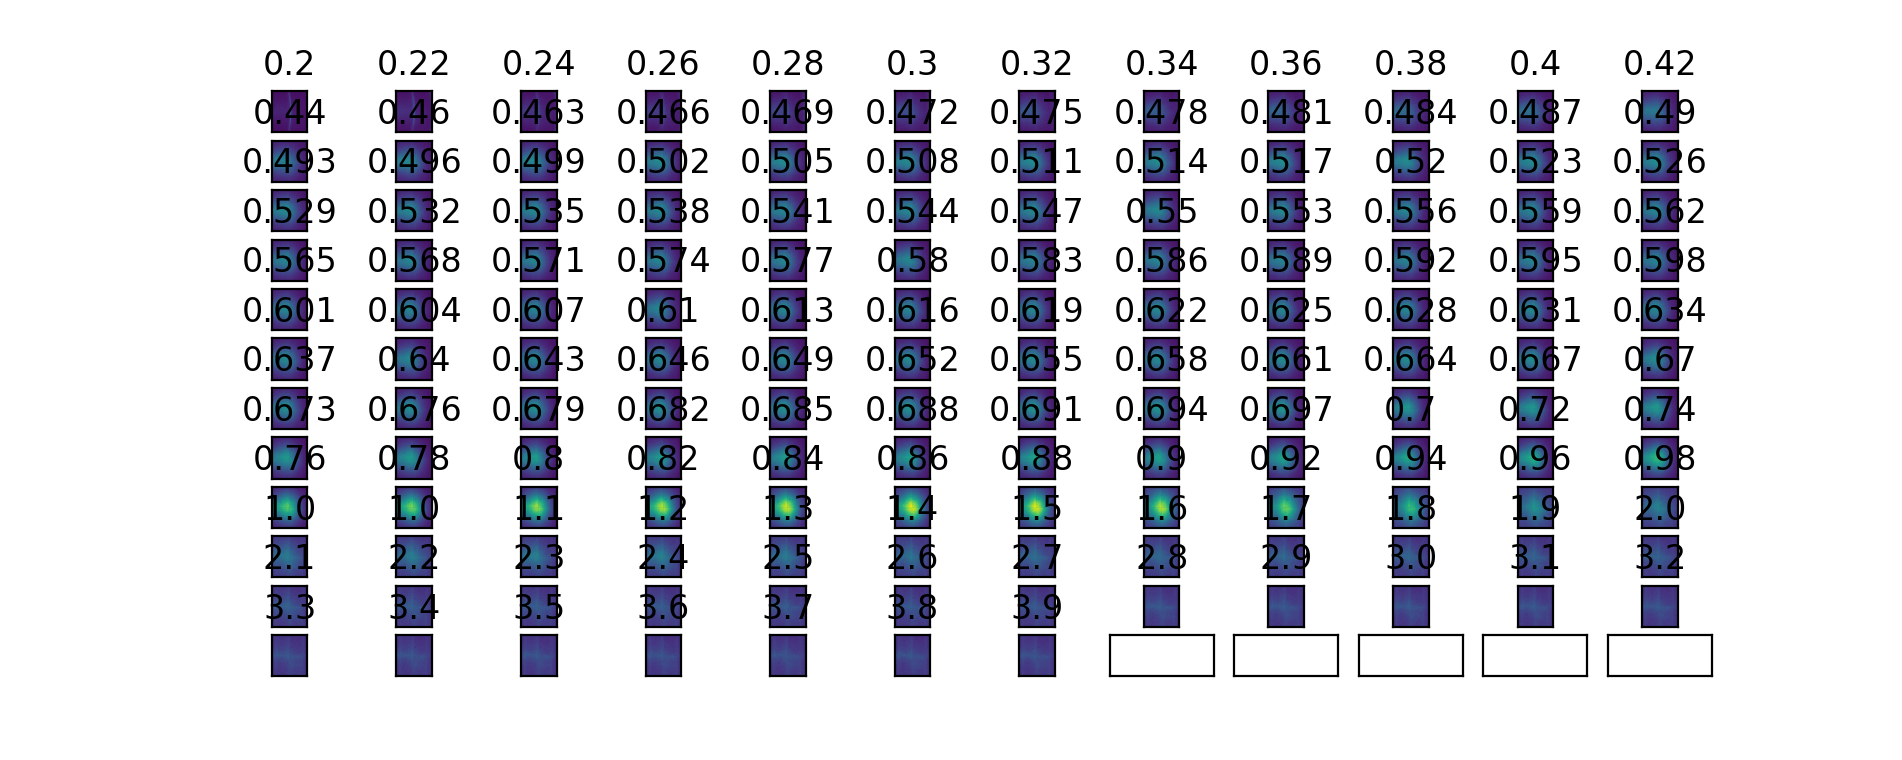

In [96]:
N = len(all_dat[0])
r, c = int(np.floor(np.sqrt(N)+1)), int(np.floor(np.sqrt(N)+1))
fig, ax = plt.subplots(r,c, figsize = (3,3))

for j, dat in enumerate([all_dat[0]]):
    for j, da in enumerate(dat):
        idx = da.find('_ai')
        ai = float(da[idx+3:idx+8])
        img=fabio.open(os.path.join(RAW_DIR, da)).data
        ax[int(np.floor(j/r)),int(j%r)].imshow(img[partial_peak], vmin=0, vmax=200)
        ax[int(np.floor(j/r)),int(j%r)].set_title(f"{ai}")
        
for ax_row in ax:
    for axis in ax_row:
        axis.set_xticks([])
        axis.set_yticks([])
        

In [97]:
print(all_dat[0])

['CM_wideincidentanglescan_A5_02_2450.00eV_ai0.200_wa0_bpm122.535_id797158_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.220_wa0_bpm122.552_id797159_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.240_wa0_bpm122.517_id797160_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.260_wa0_bpm122.587_id797161_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.280_wa0_bpm122.644_id797162_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.300_wa0_bpm122.556_id797163_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.320_wa0_bpm122.489_id797164_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.340_wa0_bpm122.513_id797165_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.360_wa0_bpm122.579_id797166_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.380_wa0_bpm122.620_id797167_000000_WAXS.tif', 'CM_wideincidentanglescan_A5_02_2450.00eV_ai0.400_wa0_bpm122.501_id797168_00000

# Load the flatfielding data

In [ ]:
# Past beamline data for flat fielding (normalizing default pixel intensities)
# Note this is done at 2478eV
CYCLE_FLAT = '2024_3'
PROPOSAL_FLAT= '314483-Freychet-Flatfielding'
FLAT_PATH = '/nsls2/data/smi/legacy/results/data/%s/%s/900KW/'%(CYCLE_FLAT, PROPOSAL_FLAT)
flatfield = fabio.open(os.path.join(FLAT_PATH, 'GF_flatfield_Sedge_2450uhighg1600_WZY11_wa30deg_2478eV_20s_id701601_000000_WAXS.tif')).data

fig,ax = plt.subplots(1,1)
ax.imshow(flatfield, vmin=0, vmax=100)
flatfield = flatfield.T
ax.set_title("Flatfielding Data")

## Data stitching and reduction (all this part is done using SMI_beamline package)

<IPython.core.display.Javascript object>


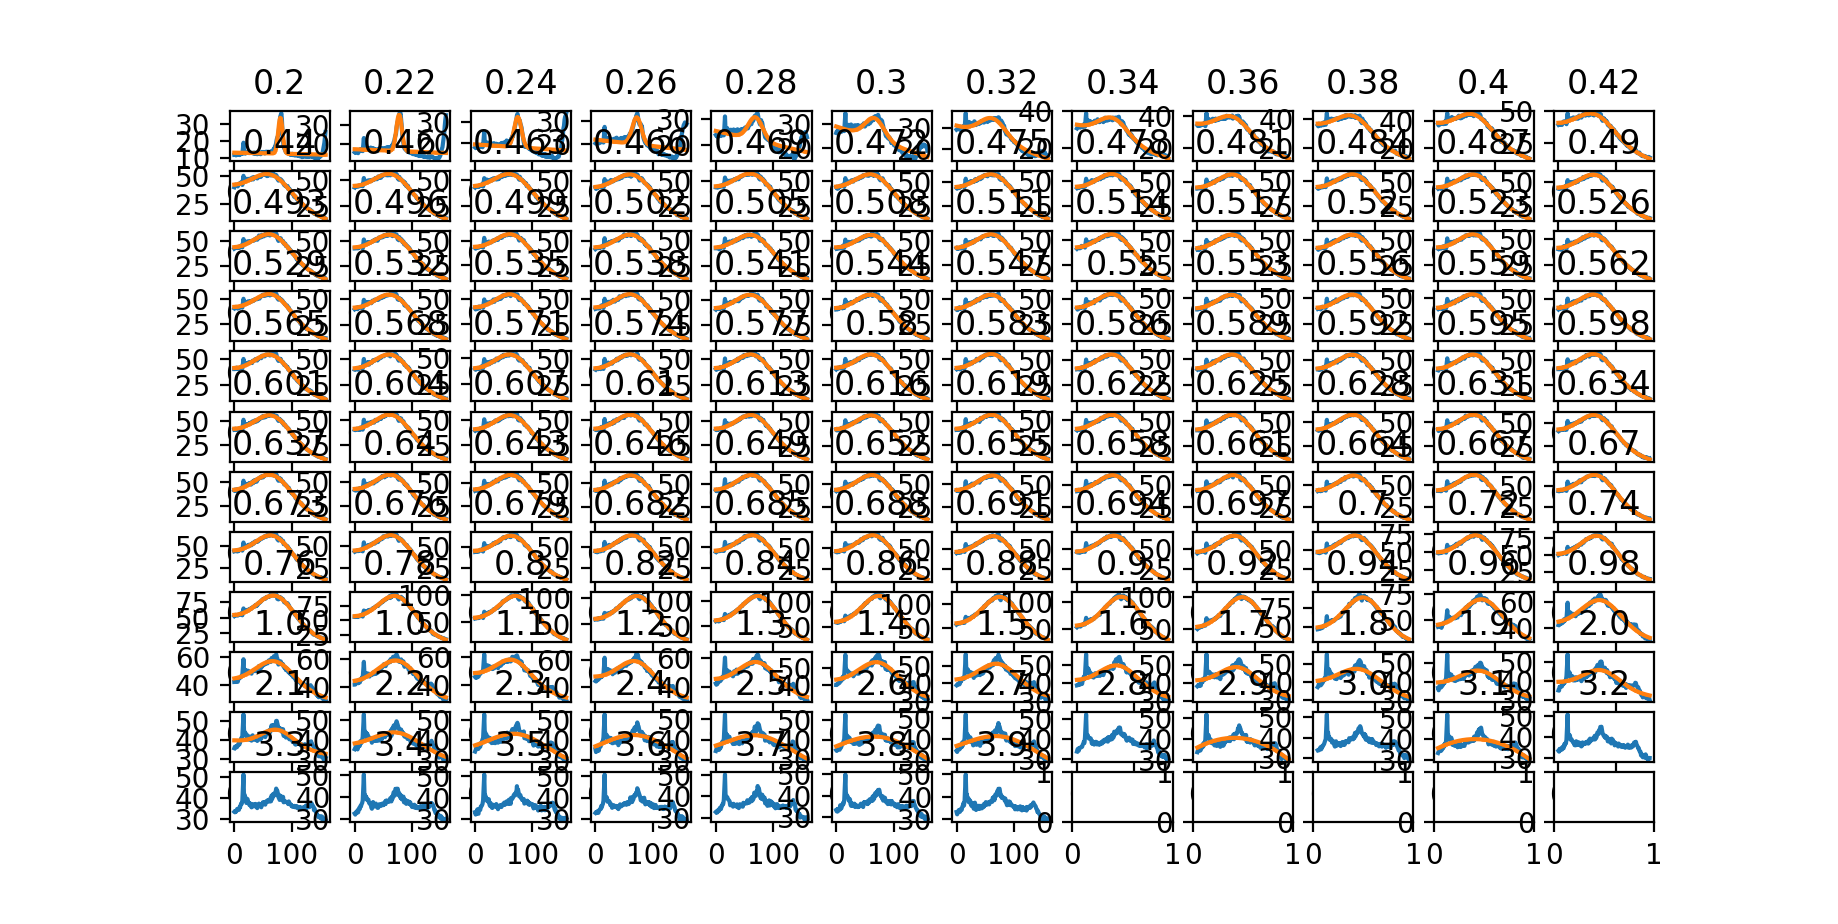

No convergence for 2.8
No convergence for 3.0
No convergence for 3.2
No convergence for 3.3
No convergence for 3.4
No convergence for 3.5
No convergence for 3.6
No convergence for 3.7
No convergence for 3.8
No convergence for 3.9
Done


array([  21.16,   19.54,   14.3 ,   11.51,    8.95,    8.7 ,    9.97,
         11.23,   13.62,   15.78,   17.77,   20.15,   23.45,   26.72,
         27.02,   28.02,   27.72,   27.47,   28.29,   28.03,   28.59,
         28.14,   28.13,   28.32,   28.08,   27.8 ,   27.66,   27.92,
         27.22,   27.54,   28.36,   27.59,   28.52,   28.08,   27.47,
         27.3 ,   26.93,   26.98,   27.09,   27.33,   27.62,   27.45,
         27.55,   27.17,   26.99,   26.61,   26.95,   26.93,   27.33,
         27.47,   27.22,   27.68,   27.72,   27.05,   28.08,   28.32,
         27.85,   28.29,   28.48,   28.42,   27.97,   28.28,   28.42,
         28.35,   28.4 ,   28.74,   28.82,   28.5 ,   29.45,   30.26,
         29.75,   30.31,   30.92,   30.28,   30.66,   30.93,   31.09,
         31.41,   31.57,   32.06,   32.28,   32.83,   33.51,   33.66,
         33.55,   34.17,   34.55,   34.36,   34.29,   36.  ,   36.91,
         36.89,   37.4 ,   38.57,   41.94,   46.46,   51.7 ,   56.82,
         61.83,   66

In [98]:
#waxs
flag_save = True
RAW_DIR = '/nsls2/data/smi/legacy/results/data/%s/%s/900KW/'%(CYCLE, PROPOSAL_ID)
ResDir = '/nsls2/data/smi/legacy/results/analysis/%s/%s/reduced_waxs/'%(CYCLE, PROPOSAL_ID)

sumall = []
sumall1 = []
sumall2 = []
enall=[]
aiall=[]
ampall=[]
errall=[]
ampall2=[]
errall2=[]

# id0 = 774550
# ia_list = np.r_[np.arange(0.2,0.46,0.02), np.arange(0.46, 0.7, 0.003), np.arange(0.7,0.9,0.002)]

N = len(all_dat[0])
r, c = int(np.floor(np.sqrt(N)+1)), int(np.floor(np.sqrt(N)+1))
fig, ax = plt.subplots(r,c, figsize = (3,3))

from scipy.stats import norm
from scipy.optimize import curve_fit

gauss = lambda x, amp, x0,gamma, grad, offset: amp*np.exp(-(x-x0)**2/(2*gamma**2)) + grad*x + offset
guess = [28.41527437, 95.61914598, 33.17924886, -0.16900728, 41.95497869]
lb = [0,        0,        0,  -20, 10]
ub = [np.inf,   np.inf , 50, 20,  70]

for i, dat in enumerate([all_dat[0]]):
    for j, da in enumerate(dat):
#         id_idx = all_dat[0][j].find("_id")
#         print(all_dat[0][j][id_idx+3: id_idx+9])
#         id_num = int(all_dat[0][j][id_idx+3: id_idx+9])
#         ia = ia_list[id_num - id0]
        idx = da.find('_ai')
        ai = float(da[idx+3:idx+8])
    
        img=fabio.open(os.path.join(RAW_DIR, da)).data
        sumall += [np.sum(img[partial_peak])]
        sumall1 += [np.sum(img[partial_beam])]
        
        hor_sum = np.mean(img[partial_peak[0]], axis=0)
        hor_sum_subset = hor_sum[partial_peak[1]]

        pixelNo = np.linspace(0,hor_sum_subset.shape[0]-1,hor_sum_subset.shape[0])
        
        p0 = (guess if popt is None else popt) #use past fit value if not None.
        
        ax[int(np.floor(j/r)),int(j%r)].plot(pixelNo, hor_sum_subset)
        ax[int(np.floor(j/r)),int(j%r)].set_title(f"{ai}")
        try:
            popt, pcov = curve_fit(gauss, pixelNo, hor_sum_subset, p0=p0)
        except RuntimeError:
            print(f"No convergence for {ai}")
            popt, pcov = [np.nan]*5, [[np.nan]*5]*5
            
        ampall += [popt[0]]
        errall += [np.sqrt(np.diag(pcov))[0]]
        
        aiall += [ai]
        
        if np.isnan(popt[0]):
            popt = None
        elif len(popt) == 5:
            ax[int(np.floor(j/r)),int(j%r)].plot(pixelNo, gauss(pixelNo, *popt), marker=".", markersize=0.2)

print('Done')
display(np.around(ampall,2))

<IPython.core.display.Javascript object>


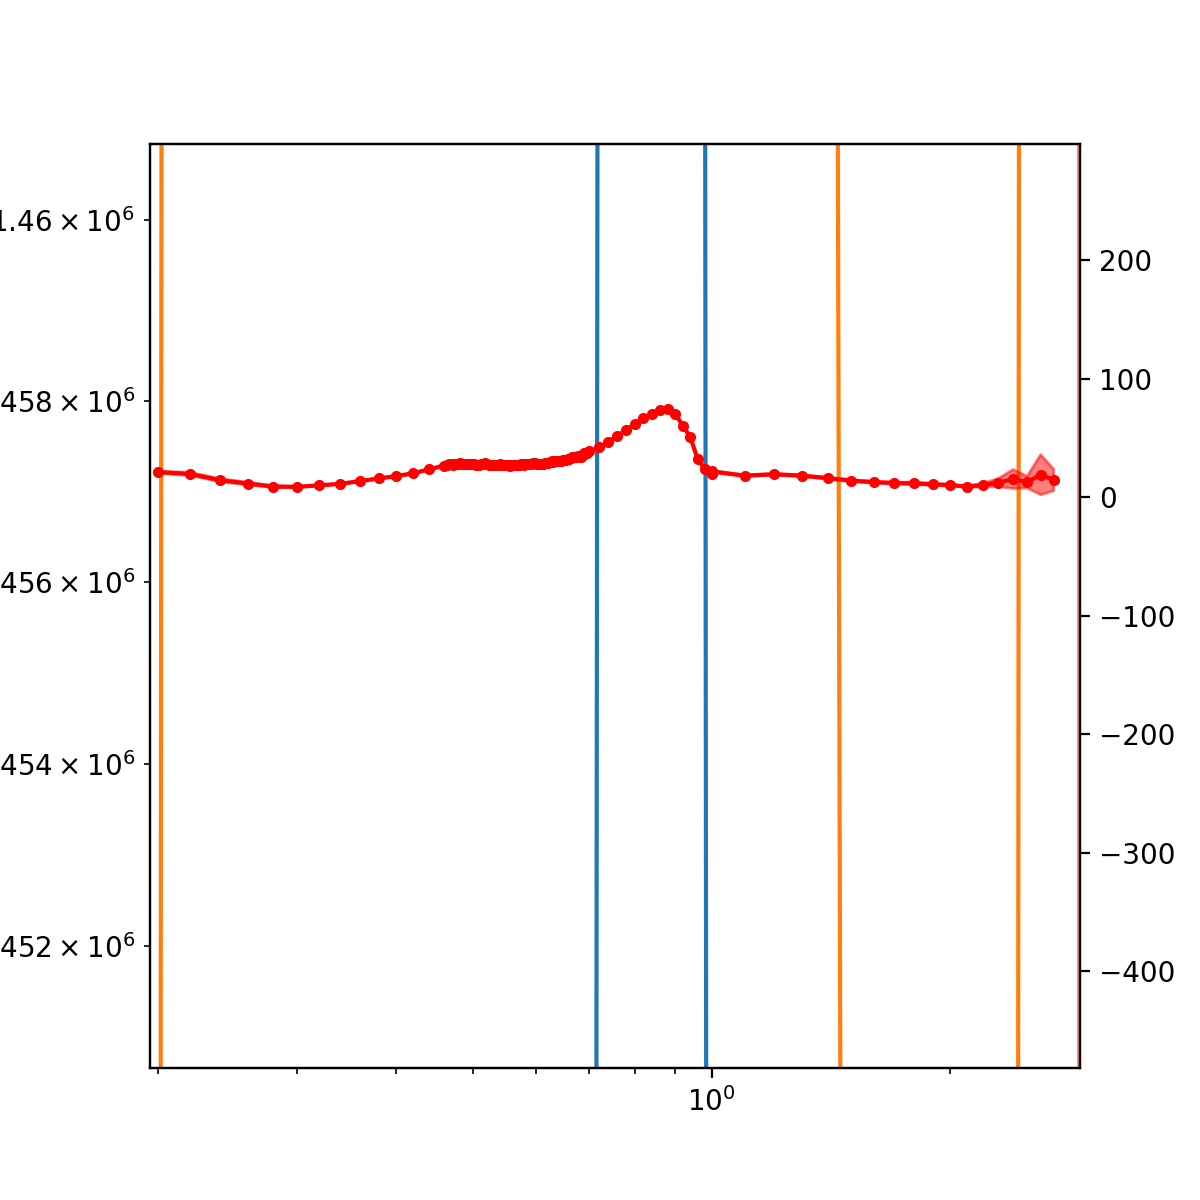

In [99]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.set_yscale("log")
idxs = np.array(aiall).argsort()
sorted_ai = np.array(aiall)[idxs]
sorted_sum = np.array(sumall)[idxs]
sorted_sum1 = np.array(sumall1)[idxs]
sorted_sumamp = np.array(ampall)[idxs]
sorted_err = np.array(errall)[idxs]
plt.plot(sorted_ai, sorted_sum, marker=".")
plt.plot(sorted_ai, sorted_sum1, marker=".")
ax2 = plt.twinx()
ax2.plot(sorted_ai, sorted_sumamp, marker=".", c="red")
ax2.fill_between(sorted_ai, sorted_sumamp - sorted_err, sorted_sumamp + sorted_err, alpha=0.5, color="red")
plt.xscale("log")
plt.show()

In [14]:
ids = [name[-22:-16] for name in  all_dat[0]]
display(min(ids), max(ids))

'784259'

'784397'